# Cajamar UniversityHack 2018 Datathon: Salesforce Predictive Modelling

#### Donkeys  | Universidad de Barcelona

- Alex Escolá Nixon
- Jaume Puigbó
- Florent Micand

#### Agenda
1. Introducción
2. Análisis Exploratorio
3. Manipulación de variables
4. Modelo y ajuste de parámetros
5. Evaluación
6. Modelo final y generación de predicciones
7. Interpretabilidad y conclusiones

### 1. Introducción

Se entiende por poder adquisitivo la capacidad de una persona por comprar bienes y servicios. Es crucial para una entidad financiera poder estimar el poder adquisitivo de sus clientes para ser capaz de ofrecerles los productos financieros más adecuados en su etapa como clientes de la entidad. Además, es una variable de gran utilidad para establecer el riesgo financiero asociado.

En este proyecto presentamos un modelo predictivo que busca estimar de manera precisa el poder adquisitivo de cada cliente, a partir de un dataset con históricos de productos, consumos, saldos, número de operaciones y datos sociodemográficos de más de 300000 clientes. Se provee un fichero Train.txt para entrenar un modelo de aprendizaje automático de 363834 registros y 88 características, más la variable Poder Adquisitivo, que nos permitirá estimar el poder adquisitivo de los 156315 usuarios del fichero Test.txt. 

Este problema de Machine Learning posee algunas particularidades, para las cuales avanzamos algunas hipótesis a continuación. En primer lugar, la variable a estimar, el poder adquisitivo, no es una magnitud real que pueda ser observada, por la propia definición o naturaleza de la misma. Los valores de poder adquisitivo que aparecen en el dataset Train.txt han sido ellos mismos calculados o estimados por la entidad financiera, probablemente a partir de reglas, algoritmos y mayor cantidad de datos, en un amplio rango temporal, utilizando su know-how y experiencia en el sector. 

En segundo lugar, dado el orden de magnitud del poder adquisitivo y de otras variables numéricas, entendemos las características del dataset como la situación financiera en un preciso momento de los clientes, una foto instantánea, con algunos de los saldos, consumos, y número de operaciones agregados para un cierto periodo, por ejemplo mensualmente, trimestralmente o anualmente. 

Si la entidad financiera ya es capaz de establecer el poder adquisitivo con suficiente fiabilidad como para lanzar un reto nacional, ¿en qué medida podemos aportar valor presentando una solución a este reto? Pensamos que el valor radica en obtener el poder adquisitivo con las limitadas características de este dataset, marcadas por su restricción temporal. Ser capaz de establecer el poder adquisitivo de nuevos clientes, de los que se tengan pocos meses de información, para ofrecerles cuanto antes los productos financieros acordes con su poder adquisitivo, en cuanto a interés del cliente y riesgo financiero.

Esta propuesta nos lleva a reflexionar sobre la evaluación más apropiada de la solución presentada a continuación. Aunque un error en términos absolutos o relativos es un buen indicador, y él que utilizaremos, podríamos aportar mayor valor de negocio conociendo umbrales de concesión de productos en término de poder adquisitivo, y así presentar un sistema de evaluación basado en probabilidad de idoneidad de producto según umbrales.

Presentamos en primer lugar un análisis exploratorio de los datos, que justifican la manipulación de variables llevada a cabo, para después probar diferentes modelos predictivos. Tras comentar la bondad del modelo final mediante el sistema de evaluación elegido, generamos el fichero de entrega con las predicciones de poder adquisitivo para los clientes incluidos en Test.txt.

### 2. Análisis Exploratorio

In [1]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
#import xgboost as xgb

In [2]:
path = "data/"
train_filename = "Dataset_Salesforce_Predictive_Modelling_TRAIN.txt"
df = pd.read_csv(path+train_filename,low_memory=False)

#Remplazamos un valor hexadecimal en la variable categórica Socio_Demo_01 por su correspondiente decimal
#para que no de problemas de tipo de datos luego.
df["Socio_Demo_01"].replace(to_replace='0X301', value=769, inplace=True)
df["Socio_Demo_01"] = df["Socio_Demo_01"].astype(np.float64)

#### 2.1 Poder adquisitivo

Empecemos por analizar los parámetros estadísticos y distribución del poder adquisitivo:

In [3]:
df['Poder_Adquisitivo'].describe()

count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64

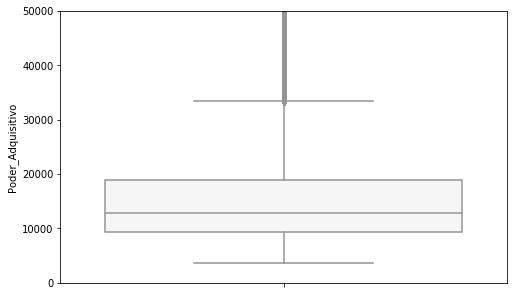

In [4]:
fig, ax =plt.subplots(1,1, figsize=(8,5))
facet =sns.boxplot(y="Poder_Adquisitivo", data=df, palette="RdBu_r", ax = ax)
facet.set(facecolor ="white")
plt.ylim(ymin=0,ymax=50000)
plt.show()

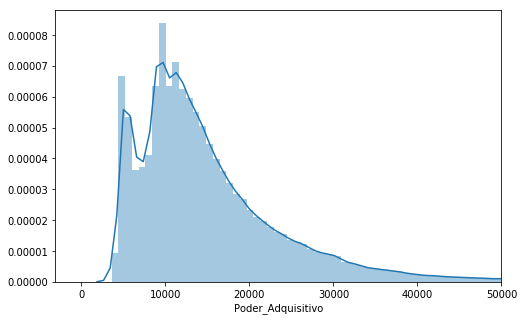

In [5]:
fig, ax =plt.subplots(1,1, figsize=(8,5))
sns.distplot(df['Poder_Adquisitivo'][df['Poder_Adquisitivo'] < 100000], ax = ax, bins = 120)
plt.xlim(xmax=50000)
plt.show()

Lo primero que podemos observar que la distribución tiene una larga cola derecha. Con lo que una buena opción, para quitar parte del peso que los outliers pueden suponer en el modelo, es transformar la variable dependiente mediante el logaritmo. De esta forma tendremos una distribución que se asemeja más a una distribución normal, por lo tanto más balanceada.

Debido a que hay una cierta cantidad de datos mucho más elevados que los demás, hemos considerado que la solución que podria tener más lógica para este problema, desde el punto de vista entidad financiera, es la de tratar estos datos por separado. Además estos valores suponen un importante empeoramiento de los resultados del regresor utilizado. 

Teniendo ello en cuenta, hemos decidido prescindir de los clientes cuyo poder adquisitivo sea superior a aproximadamente los 200.000€, lo que supone quitar el percentil 0.1% de la parte superior de la distribución. Esto podría empeorar la predicción del modelo para clientes de poder adquisitivo muy alto, proponiendo por ejemplo valores cercanos a 200000€ y no a 1 millón. Este error no es relevante teniendo en cuenta que la entidad financiera seguramente provee una atención personalizada a clientes de muy alto poder adquisitivo a través de un asesor financiero.

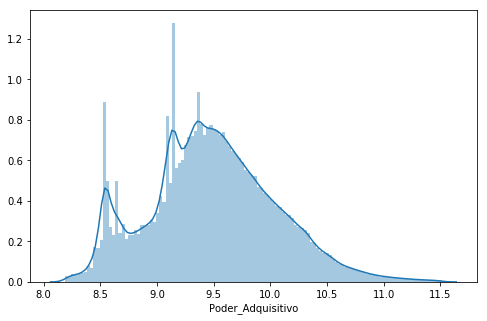

In [6]:
fig, ax =plt.subplots(1,1, figsize=(8,5))
sns.distplot(np.log(df['Poder_Adquisitivo'][df['Poder_Adquisitivo'] < 100000]), ax = ax, bins = 120)
plt.show()

#### 2.2 Tenencia de los productos financieros </h3>

Realizamos un analisis exploratorio de las variables categoricas que indican la tenencia de los distintos productos financieros.
Observamos las distribuciones de la cantidad de ceros, unos y doses que contienen cada una de la variables de Ind_Prod, las cuales indican respectivamente si no existe tenencia en los distintos productos financieros, si sí existe, o si ha existido en los últimos tres meses.

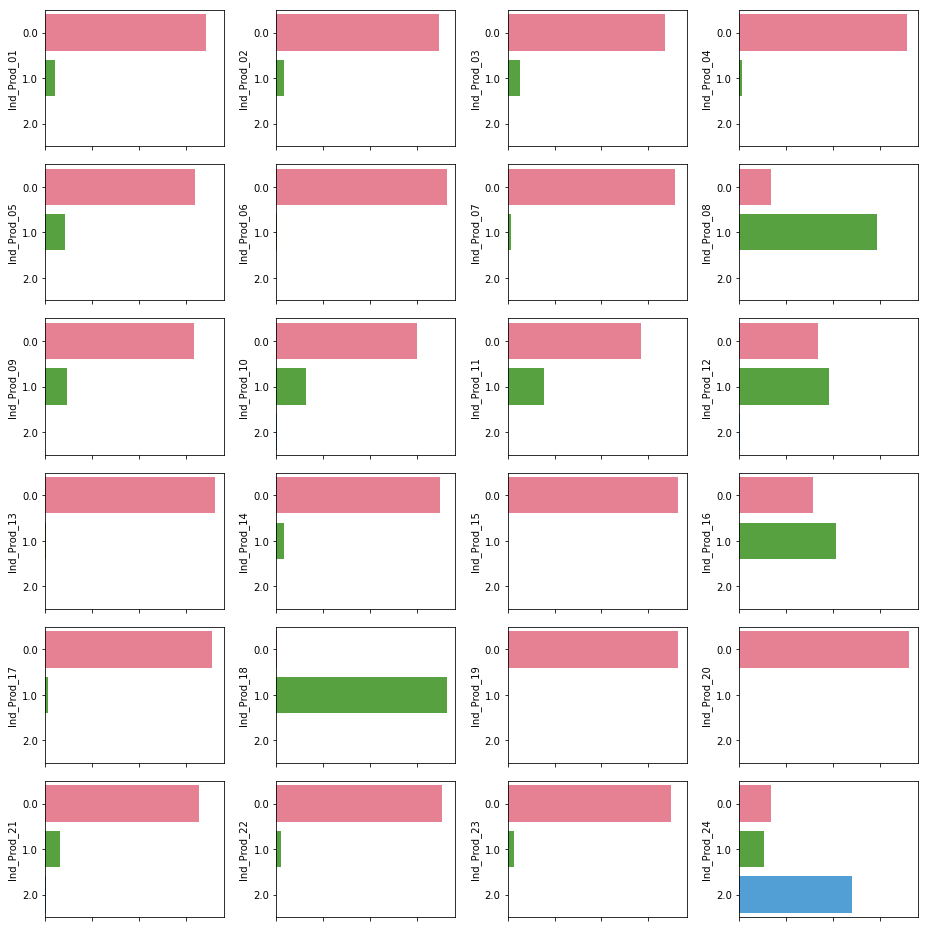

In [7]:
Ind_Prods = df.loc[:,'Ind_Prod_01':'Ind_Prod_24']
for col in Ind_Prods.columns:
    Ind_Prods.loc[:,col] = Ind_Prods.loc[:,col].astype(float)
    
fig, axes =plt.subplots(6,4, figsize=(13,13), sharex=True)
axes = axes.flatten()
for ax, catplot in zip(axes, Ind_Prods.columns):
    sns.countplot(y=catplot, data=Ind_Prods, ax=ax, 
                  order=np.unique(Ind_Prods.values), palette="husl")
    ax.set_xlabel('')
ax.set_xticklabels([])
plt.tight_layout()  
plt.show()

Por lo general, son pocos los casos en los que exista tenencia de productos financieros. La cantidad de doses en todos los casos es todavía más minoritaria. Teniendo en cuenta esta información, veamos más en detalle que utilidad pueden tener cada una de estas variables de cara a predecir el poder adquisitivo de un cliente. 

Para ello en la siguiente figura vemos para cada variable, la distribución del poder adquisitivo correspondiente a los clientes seccionados según los distintos valores que tóma cada Ind_Prod, es decir, 0,1 o 2.

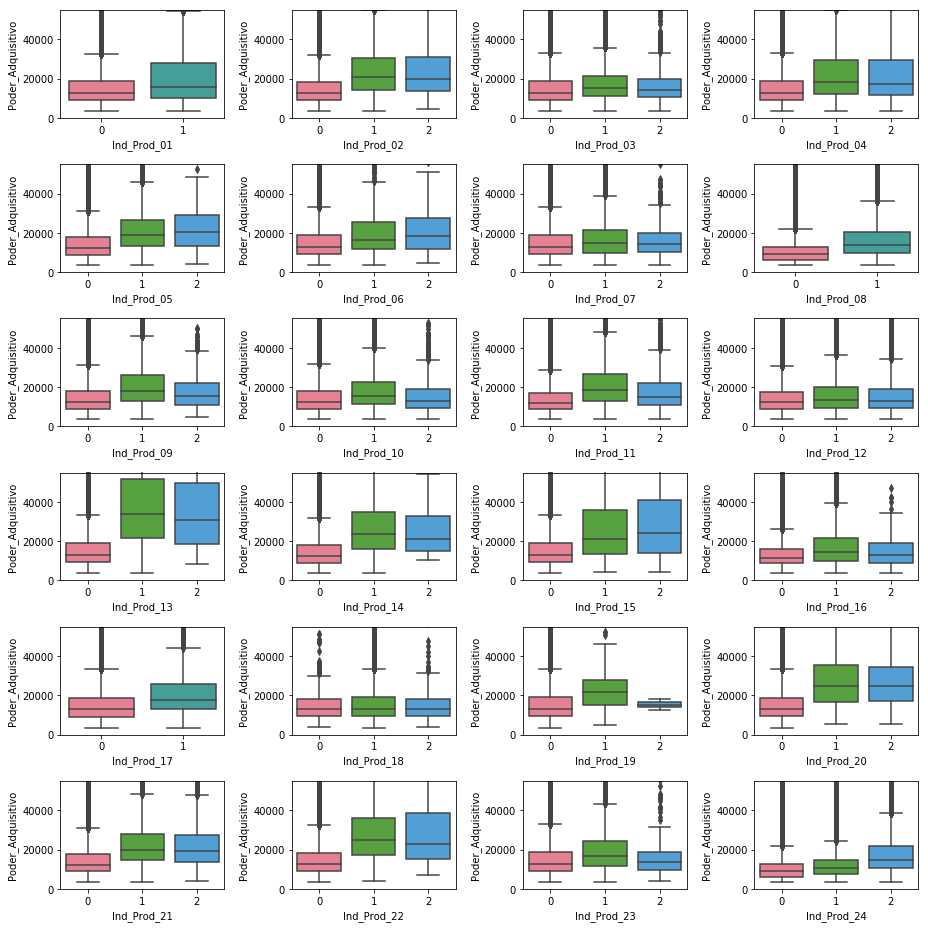

In [8]:
fig, axes = plt.subplots(6,4, figsize=(13,13), sharex=False)
axes = axes.flatten()
for ax, catplot in zip(axes, Ind_Prods.columns):
    data_temp = pd.concat([df['Poder_Adquisitivo'], df[catplot]], axis=1)
    sns.boxplot(x=catplot, y="Poder_Adquisitivo", data=data_temp, ax=ax, palette="husl")
    ax.set_ylim(bottom=0,top=55000)
plt.tight_layout()  
plt.show()

Si dejamos de lado por un momento los diagramas de cajas correspondientes a los doses de cada variable, vemos que las correspondientes distribuciones del poder adquisitivo varían bastante dependiendo de la tenencia de los distintos productos financieros. Ello nos está indicando por lo tanto que por lo general (exceptuando algunos casos como por ejemplo 'Ind_Prod_18'), dichas variables pueden resultar útiles para predecir el poder adquisitivo. 

También se observa que en la mayoría de casos la distribución del poder adquisitivo es parecida para los casos en los que sí se posee el producto financiero y para aquellos en los que la ha habido los últimos 3 meses. Por lo que, si añadimos el hecho de que la cantidad de doses es muy minoritaria, parece una buena opción tratar éstos dos útlimos como una sola variable. 

Por lo que a excepción de Ind_Prod_24, para la que sí se aprecia un importante augmento de media del poder adquisitivo en los clientes con un 2, los doses serán tratados como unos, de esta forma, debido a que las variables categóricas deben ser convertidas a OneHot, pasaríamos de tener tres columnas para cada variable (una para cada posible valor), a una sola.

A continuación analicemos si existen correlaciones entre productos:

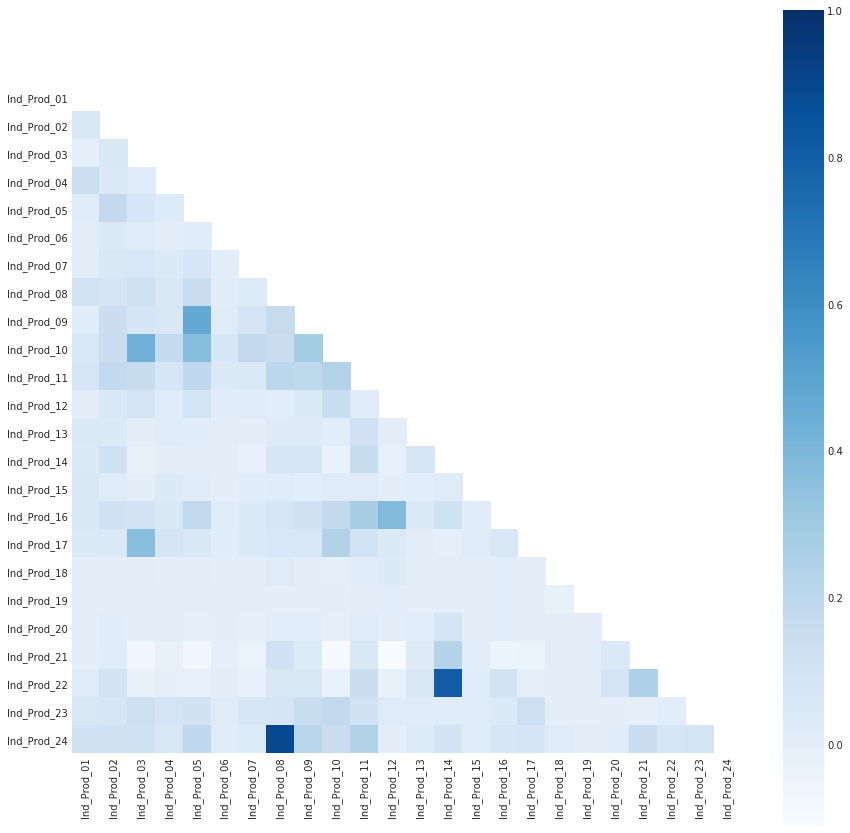

In [9]:
corr = Ind_Prods.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15,15))
    sns.heatmap(corr, mask=mask, square=True, annot=False, cmap='Blues', ax=ax)
    plt.xticks(rotation=90, ha='center');
plt.show()

A primera vista las correlaciones cruzadas entre las variables son bajas. A excepción de alguna como es la correlación de 'Ind_Prod_08' con 'Ind_Prod_24', con una correlación del 89%:

In [10]:
np.corrcoef(Ind_Prods['Ind_Prod_24'],Ind_Prods['Ind_Prod_08'])

array([[1.        , 0.89702905],
       [0.89702905, 1.        ]])

No obstante si analizamos un poco más en detalle ambas variables, nos damos cuenta de que la correlacón se debe a que ambas variables contienen los ceros en las mismas posiciones.:

In [11]:
matches_of_zeros = len(np.intersect1d(list(np.where(Ind_Prods['Ind_Prod_24'] == 0)[0]), 
                             list(np.where(Ind_Prods['Ind_Prod_08'] == 0)[0])))
print('Posiciones en que coinciden los ceros:', matches_of_zeros)
print("Cantidad de ceros:", len(Ind_Prods[Ind_Prods['Ind_Prod_24'] == 0]))

Posiciones en que coinciden los ceros: 68543
Cantidad de ceros: 68543


Por lo que, teniendo en cuenta que 'Ind_Prod_24' contiene una gran cantidad de doses, y que la distribución del poder adquisitivo es más elevada para los usuarios con un dos como se ha argumentado previamente, ello nos indica que dicha información puede resultar valiosa de cara a la predicción. Por lo que podemos suponer que la variable 'Ind_Prod_08' no nos está aportando información disponiendo de 'Ind_Prod_24'.

También vemos una correlación significativa entre las variables 'Ind_Prod_14' y 'Ind_Prod_22'. En este caso se debe a que las posiciones contienen unos en las mismas posiciones. Pero los demás valores que contienen las categorías aportan información distinta por lo que no podemos realizar asunciones como con el caso previo.

Observando la gráfica de diagramas de caja de los valores categóricos vs el poder adquisitivo, vemos que 'Ind_Prod_18', además de contener unos casi en la totalidad de los casos, las distribuciones de los ceros y unos en dicha variable son muy parecidas. Por lo que cabe suponer que esta variable no aporta mucha información de cara a la predicción.

#### 2.3 Importe de los saldos de los distintos productos financieros </h3>

Para el análisis de dichas variables, empecemos por ver la cantidad de ceros que tiene cada una:

In [12]:
Imp_Sals = df.loc[:,'Imp_Sal_01':'Imp_Sal_21']
for i in Imp_Sals.columns:
    print (i, 'contiene', len(df[i][df[i]!=0]), 'valores distintos a 0')

Imp_Sal_01 contiene 854 valores distintos a 0
Imp_Sal_02 contiene 101501 valores distintos a 0
Imp_Sal_03 contiene 952 valores distintos a 0
Imp_Sal_04 contiene 43350 valores distintos a 0
Imp_Sal_05 contiene 27163 valores distintos a 0
Imp_Sal_06 contiene 7437 valores distintos a 0
Imp_Sal_07 contiene 1615 valores distintos a 0
Imp_Sal_08 contiene 358862 valores distintos a 0
Imp_Sal_09 contiene 352781 valores distintos a 0
Imp_Sal_10 contiene 295291 valores distintos a 0
Imp_Sal_11 contiene 283 valores distintos a 0
Imp_Sal_12 contiene 34383 valores distintos a 0
Imp_Sal_13 contiene 10283 valores distintos a 0
Imp_Sal_14 contiene 0 valores distintos a 0
Imp_Sal_15 contiene 66000 valores distintos a 0
Imp_Sal_16 contiene 175182 valores distintos a 0
Imp_Sal_17 contiene 1156 valores distintos a 0
Imp_Sal_18 contiene 3978 valores distintos a 0
Imp_Sal_19 contiene 356416 valores distintos a 0
Imp_Sal_20 contiene 177124 valores distintos a 0
Imp_Sal_21 contiene 361409 valores distintos a 

Vemos claramente, que muchas de ellas contienen muy poca información y no aportarían valor de cara a la regresión. Ello ha sido además corroborado con el análisis de la importancia de cada variable obtenido a partir del mismo regresor XGBoostRegressor con el que se ha realizado la predicción. No obstante, como comentamos, ello será corroborado con la importancia de las variables obtenidas con el mismo modelo, ya que, para algunos casos como es el de Imp_Sal_07, aun contener muy poca información sí resulta útil para el modelo.
Por lo que dichas variables no serán utilizadas en el modelo.

In [13]:
to_drop = ['Imp_Sal_01', 'Imp_Sal_03', 'Imp_Sal_11', 'Imp_Sal_14', 'Imp_Sal_17']
low_values = ['Imp_Sal_06', 'Imp_Sal_07', 'Imp_Sal_12', 'Imp_Sal_13', 'Imp_Sal_18']
Imp_Sal_hist = pd.concat([Imp_Sals, df.loc[:,'Poder_Adquisitivo']], axis = 1)\
                        .drop(to_drop, axis = 1).drop(low_values, axis = 1)

A continuación veamos los histogramas de las siguientes variables:

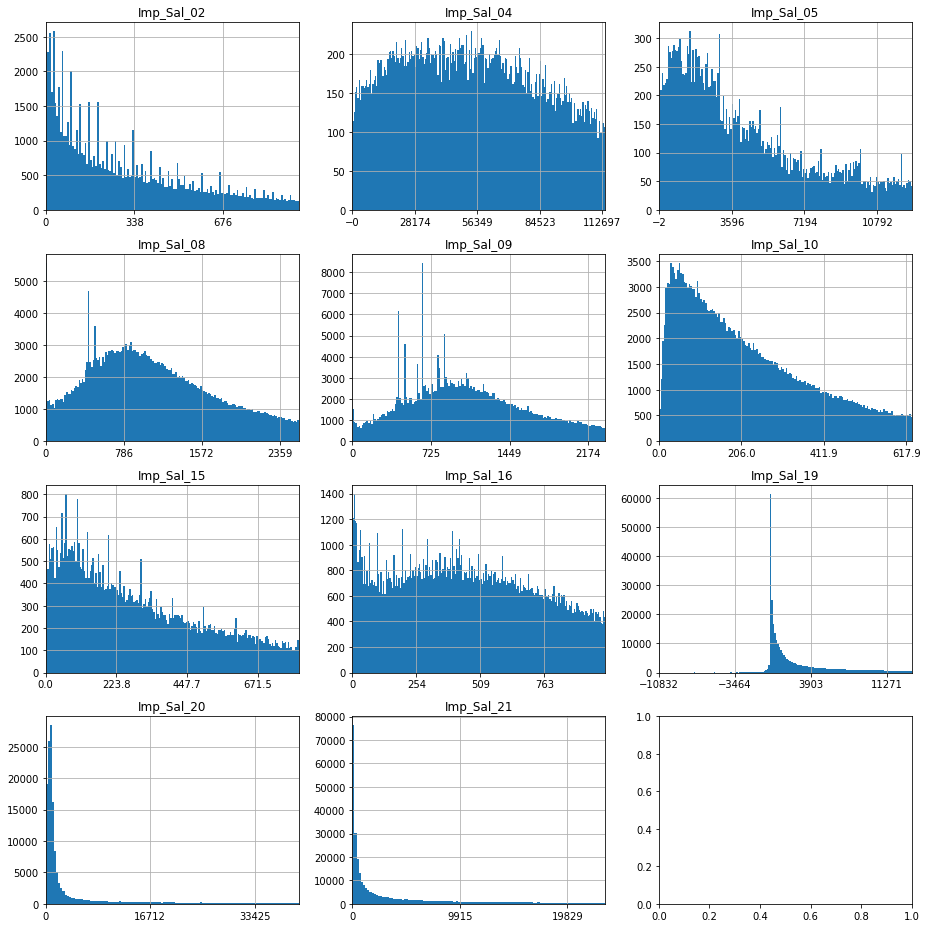

In [14]:
fig, axes = plt.subplots(4,3, figsize=(13,13), sharex=False)
axes = axes.flatten()
for ax, catplot in zip(axes, Imp_Sal_hist.columns[:-1]):
    train_subplot = Imp_Sal_hist[Imp_Sal_hist[catplot] != 0]
    data_to_plot = train_subplot[catplot][train_subplot[catplot] < np.percentile(train_subplot[catplot], 90)]
    data_to_plot.hist(bins = 250, ax=ax)
    ax.set_title(catplot)
    ax.xaxis.set_ticks(np.arange(min(data_to_plot), max(data_to_plot)+1, (max(data_to_plot) - min(data_to_plot)+1)/5.))
    ax.set_xlim(xmin = data_to_plot.min(), xmax=np.percentile(data_to_plot, 90))
plt.tight_layout()  
plt.show()

Lo primero que observamos es la evidente asimetría estadística que poseen todas las variables. Vemos que el importe de los saldos de los distintos productos financieros son por lo general bajos, con una frecuencia menguante para importes más altos. Por lo que también podría plantearse la tranformación logarítmica de estas variables, con tal de quitar peso a la mayor variabilidad que tendrán los valores más elevados de éstas, para ver si benefician al modelo.

In [15]:
Log_Imp_Sal = [u'Imp_Sal_02', u'Imp_Sal_08',
       u'Imp_Sal_09', u'Imp_Sal_10', u'Imp_Sal_15', u'Imp_Sal_16',
       u'Imp_Sal_19', u'Imp_Sal_20', u'Imp_Sal_21']
def log_transform(df,col):
    return pd.DataFrame(np.log(df[col] + 1 + abs(min(df[col]))), columns = [col])

C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


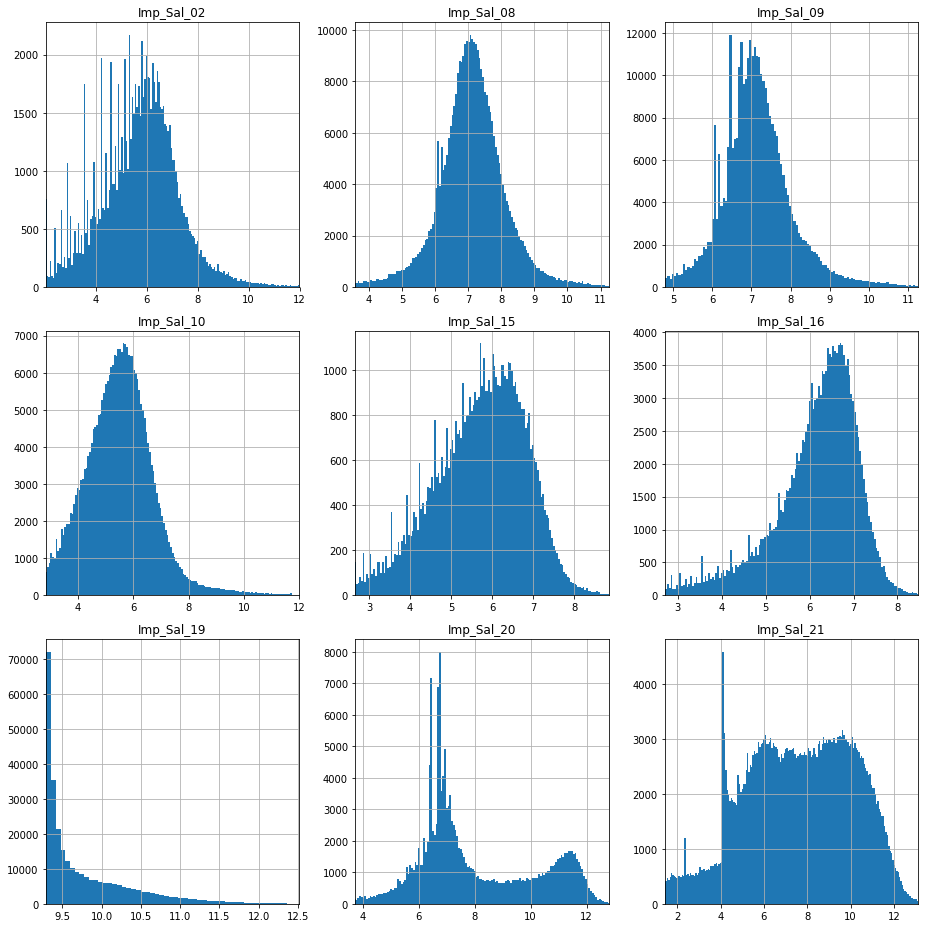

In [16]:
fig, axes = plt.subplots(3,3, figsize=(13,13), sharex=False)
axes = axes.flatten()
for ax, catplot in zip(axes, Log_Imp_Sal):
    train_subplot = Imp_Sal_hist.loc[Imp_Sal_hist[catplot] != 0]
    train_subplot.loc[:,catplot] = log_transform(train_subplot, catplot)
    train_subplot.loc[:,catplot].hist(bins = 250, ax=ax)
    ax.set_xlim(xmin = np.percentile(train_subplot[catplot], 2), xmax=np.percentile(train_subplot[catplot], 99.9))
    ax.set_title(catplot)
plt.tight_layout()  
plt.show()

Vemos que de esta forma también resulta más fácil extraer información relevante de las distribibuciones al asemejarse más a distribuciones normales. Vemos por ejemplo que Imp_Sal_20 posee una distribución claramente bimodal:

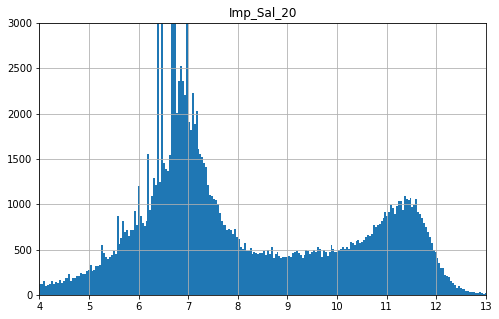

In [17]:
fig, ax =plt.subplots(1,1, figsize=(8,5))
log_transform(df,'Imp_Sal_20').hist(bins = 400, ax=ax)
plt.xlim(xmin=4, xmax = 13)
plt.ylim(ymax = 3000)
plt.show()

Por lo que, teniendo en cuenta que ésta es una variable importante para el modelo como mostramos más adelante, una opción que hemos analizado es tratar ambas modas de dicha variable por separado, con lo que cada una se asemejaría más a una distribución normal. En este preciso caso no ha mejorado la predicción.

Analicemos ahora algunas de las correlaciones existentes entre las variables de saldo más destacadas:

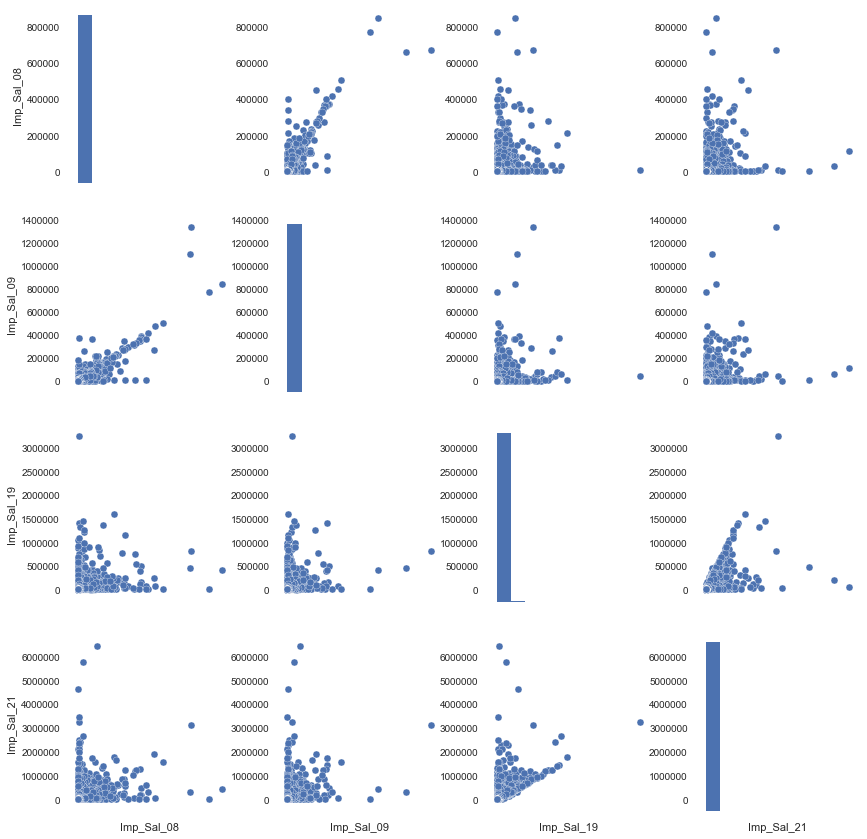

In [18]:
sns.set()
g = sns.pairplot(df[['Imp_Sal_08', 'Imp_Sal_09', 'Imp_Sal_19', 'Imp_Sal_21']], size = 3)
g.set(xticklabels=[], facecolor ="white")
plt.show();

Observamos que existe cierta relación entre las variables. Por ejemplo, el importe del salario del producto financiero 19 marca un cierto umbral inferior en el del 21. Sin embargo, la correlación entre ambas no es suficientemente alta como para no utilizar alguna de ellas.

No obstante sí existe una alta correlación el 8 i el 9:

In [19]:
np.corrcoef(df.Imp_Sal_08,df.Imp_Sal_09)

array([[1.        , 0.87472757],
       [0.87472757, 1.        ]])

Al estar correlacionadas casi al 90%, en este caso sí podriamos considerar el utilizar tan solo una de ellas para evitar que ello afecte al modelo, o dar demasiado peso a esta variable que, en cierto modo podemos considerar que aporta la misma información. Sin embargo la incidencia de tener variables correlacionadas es posteriormente analizada a partir de los resultados debido a que el XGBRegressor es robusto a correlaciones entre variables.

Viendo más en detalle la distribución de ambas, vemos que son casi idénticas:

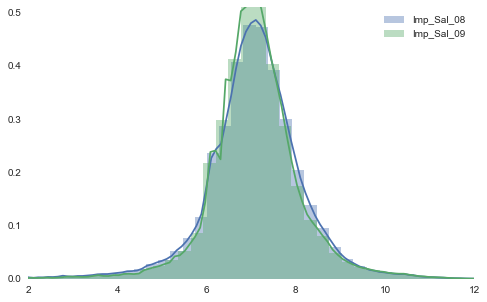

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
for a in [log_transform(df,'Imp_Sal_08'), log_transform(df,'Imp_Sal_09')]:
    g = sns.distplot(a, bins=50, ax=ax, label=a.columns[0])
    g.set(facecolor = "white")
ax.set_xlim([2, 12])
ax.set_xlabel('')
plt.legend()
plt.show()

También analizando las correlaciones de las variables con el poder adquisitivo, hemos considerado interesante comentar el comportamiento de Imp_Sal_21. Como podemos observar en el siguiente diagrama de dispersión de dicha variable con el poder adquisitivo, vemos que el importe del salario del producto 21 marca un cierto umbral inferior de poder adquisitivo. Ello nos indica que dicha variable posiblemente sea útil de cara a predecir el poder adquisitivo, ya que para ciertos importes el poder adquisitivo, como se observa, no baja de cierto mínimo.

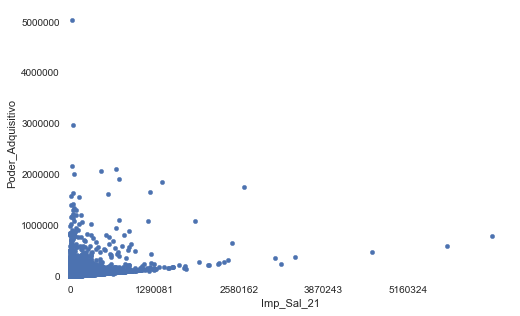

In [21]:
fig, ax = plt.subplots(figsize = (8,5))
g = df.plot.scatter(x='Imp_Sal_21', y='Poder_Adquisitivo', ax = ax)
g.set(facecolor = "white")
plt.xticks(np.arange(min(df.Imp_Sal_21), max(df.Imp_Sal_21)+1, (max(df.Imp_Sal_21)+1 - min(df.Imp_Sal_21))/5.))
plt.ylim(ymin=-50000)
plt.xlim(xmin=-50000)
plt.show()

#### 2.4 Importe de consumos habituales del cliente en base a sus operaciones con tarjetas y domiciliaciones más comunes </h3>

Veamos que distribuciones tienen estas variables:

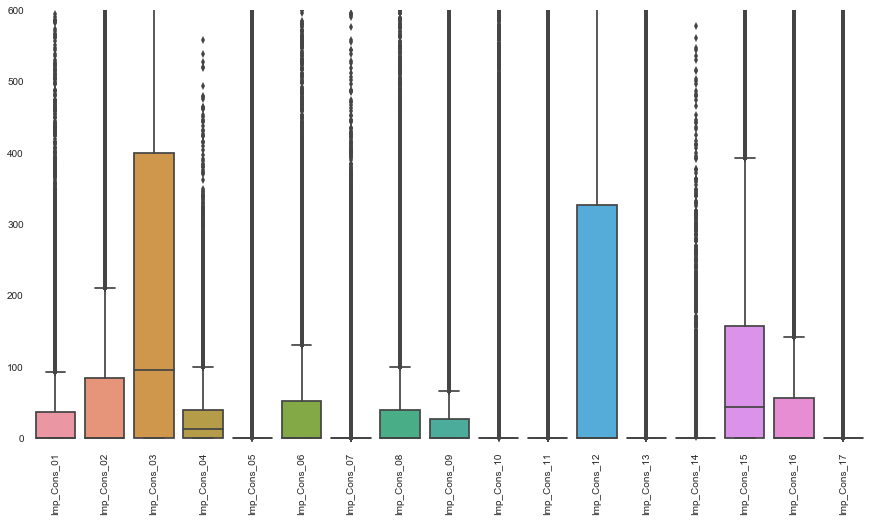

In [22]:
Imp_Cons = df.loc[:,'Imp_Cons_01':'Imp_Cons_17']

fig, ax = plt.subplots(figsize = (15,8))
g = sns.boxplot(data=np.array(Imp_Cons), ax = ax)  
g.set(facecolor = "white")
ax.set(ylim=(-10, 600))
plt.xticks(np.arange(len(Imp_Cons.columns)), (Imp_Cons.columns), rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Toman rangos de valores bastante distintos, con algunas de ellas muy concentradas en 0, debido a la gran cantidad de ceros que tienen algunas de ellas. 

Veamos las distribuciones de estas variables en forma de histogramas también, tomando la transformación logarítmica para una mejor observación de sus respectivas distribuciones:

C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


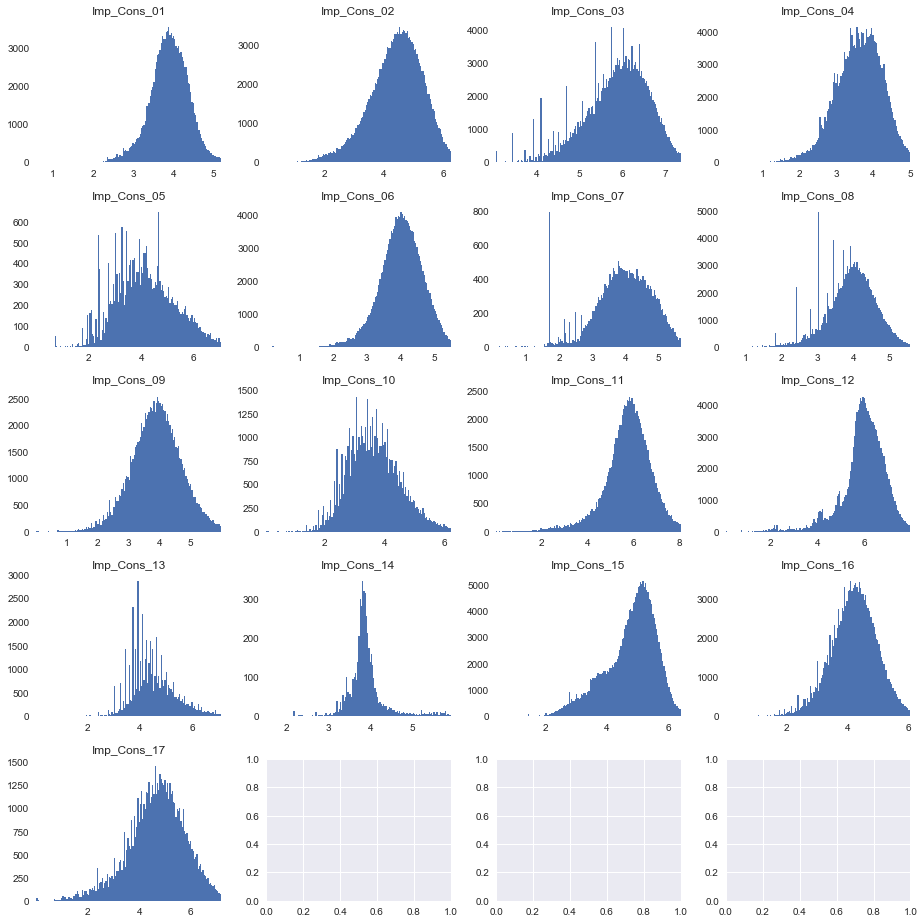

In [23]:
fig, axes = plt.subplots(5,4, figsize=(13,13), sharex=False)
axes = axes.flatten()
for ax, catplot in zip(axes, Imp_Cons.columns):
    train_subplot = Imp_Cons[Imp_Cons[catplot] != 0]
    train_subplot.loc[:,catplot] = np.log(train_subplot[catplot] + 1 + abs(min(train_subplot[catplot])))
    g = train_subplot[catplot][train_subplot[catplot] < np.percentile(train_subplot[catplot], 99)].hist(bins = 150, ax=ax)
    g.set(facecolor = "white")
    ax.set_xlim(xmin = train_subplot[catplot].min(), xmax=np.percentile(train_subplot[catplot], 99))
    ax.set_title(catplot)
plt.tight_layout()  
plt.show()

Veamos ahora si existen correlaciones destacables entre las variables:

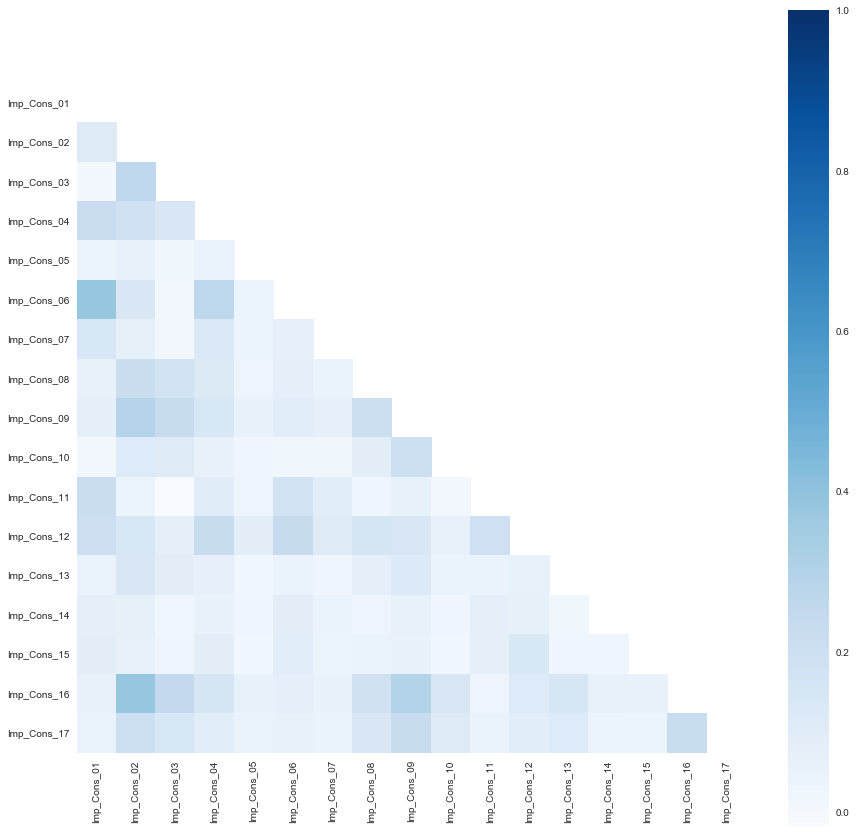

In [24]:
corr = Imp_Cons.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15,15))
    sns.heatmap(corr, mask=mask, square=True, annot=False, cmap='Blues', ax = ax)
    plt.xticks(rotation=90, ha='center');
plt.show()

En este caso vemos que existe muy poca correlación entre las variables.

#### 2.5 Datos socio-demográficos 

Como viene especificado, Socio_Demo_01 es una variable categórica. Por lo que una opción es generar dummies con cada uno de los posible valores:

In [25]:
len(df.Socio_Demo_01.unique())

509

Sin embargo ello sigue suponiendo generar más de 500 variables nuevas. Por lo que una opción es quedarse con la información más relevante mediante un bucketing de la variable.

Para explicar mejor el proceso, veamos como depende el poder adquisitivo del cliente en función de dicha variable.

In [26]:
mean_adq_power = df.groupby('Socio_Demo_01').mean()['Poder_Adquisitivo']

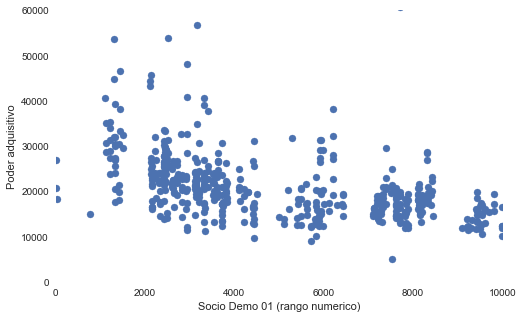

In [27]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.set_facecolor('white')
g = plt.scatter(mean_adq_power.index,mean_adq_power.values)
plt.ylim(ymin=0,ymax=60000)
plt.xlim(xmin=0,xmax=10000)
plt.xlabel('Socio Demo 01 (rango numerico)')
plt.ylabel('Poder adquisitivo')
plt.show()

Vemos que existe una gran variabilidad en el poder adquisitivo en función del valor categórico que toma Socio_Demo_01. 
Por lo que para no desperdiciar información relevante que puede proporcionar esta variable, una opción es seleccionar las categorias de que toma dicha variable para las cuales el poder adquisitivo es más extremo. 

Para ello hemos creado dos variables nuevas, una en la cual hemos introducido unos si la categoría forma parte de las 100 categorías con mayor poder adquisitivo de media, y la otra variable equivalentemente pero para el menor poder adquisitivo.

In [28]:
def buckets(df):

    sumation_SD1 = df.Poder_Adquisitivo.groupby(df.Socio_Demo_01).sum()
    count_SD1 = df.Poder_Adquisitivo.groupby(df.Socio_Demo_01).count()
    avg_sum_SD1 = sumation_SD1/count_SD1

    temp = avg_sum_SD1.argsort().reset_index()
    bucket_1 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[-30:]
    bucket_2 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[-100:-30]
    bucket_3 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[:100]
    return bucket_1,bucket_2,bucket_3

bucket_1,bucket_2,bucket_3 = buckets(df)

In [29]:
mean_adq_power = df.groupby('Socio_Demo_01').mean()['Poder_Adquisitivo']
high = mean_adq_power[bucket_1]
medium_high = mean_adq_power[bucket_2]
low = mean_adq_power[bucket_3]
others = mean_adq_power[(~mean_adq_power.index.isin(bucket_1)) & (~mean_adq_power.index.isin(bucket_2))\
                       & (~mean_adq_power.index.isin(bucket_3))]

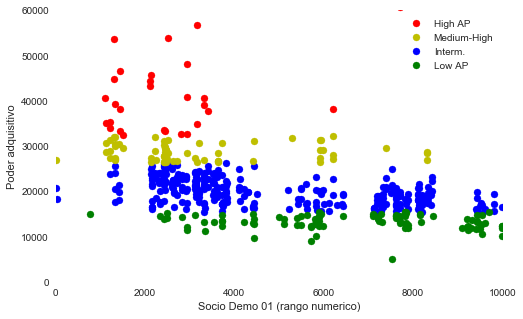

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.set_facecolor('white')

blue = plt.scatter(others.index,others.values, c='b')
yellow =  plt.scatter(medium_high.index,medium_high.values, c='y')
red = plt.scatter(high.index,high.values, c='r')
green = plt.scatter(low.index,low.values, c='g')
plt.legend((red,yellow,blue,green),
           ('High AP','Medium-High','Interm.', 'Low AP'))
plt.ylim(ymin=0,ymax=60000)
plt.xlim(xmin=0,xmax=10000)
plt.xlabel('Socio Demo 01 (rango numerico)')
plt.ylabel('Poder adquisitivo')
plt.show()

De esta forma evitamos generar una gran cantidad de variables nuevas y mantenemos cierta información que nos puede proporcionar esta variable.

#### 2.6 Número de operaciones a través de los distintos productos financieros </h3>

Empecemos por ver primero, la cantidad de entradas distintas a 0 que tienen estas variables:

In [31]:
Num_Opers = df.loc[:,'Num_Oper_01':'Num_Oper_20']

for i in df.loc[:,'Num_Oper_01':'Num_Oper_20'].columns:
    print (i, 'has', len(df[i][df[i]!=0]), 'entries different than 0')

Num_Oper_01 has 87839 entries different than 0
Num_Oper_02 has 62443 entries different than 0
Num_Oper_03 has 169450 entries different than 0
Num_Oper_04 has 1093 entries different than 0
Num_Oper_05 has 353630 entries different than 0
Num_Oper_06 has 345054 entries different than 0
Num_Oper_07 has 35073 entries different than 0
Num_Oper_08 has 55297 entries different than 0
Num_Oper_09 has 146035 entries different than 0
Num_Oper_10 has 145702 entries different than 0
Num_Oper_11 has 452 entries different than 0
Num_Oper_12 has 1042 entries different than 0
Num_Oper_13 has 25705 entries different than 0
Num_Oper_14 has 6098 entries different than 0
Num_Oper_15 has 43246 entries different than 0
Num_Oper_16 has 932 entries different than 0
Num_Oper_17 has 295291 entries different than 0
Num_Oper_18 has 77800 entries different than 0
Num_Oper_19 has 191794 entries different than 0
Num_Oper_20 has 1409 entries different than 0


Vemos que, del mismo modo que con el importe de los saldos de los productos, hay algunas con muy poca información, por lo que podemos prescindir de ellas.

Veamos ahora las distribuciones de estas variables:

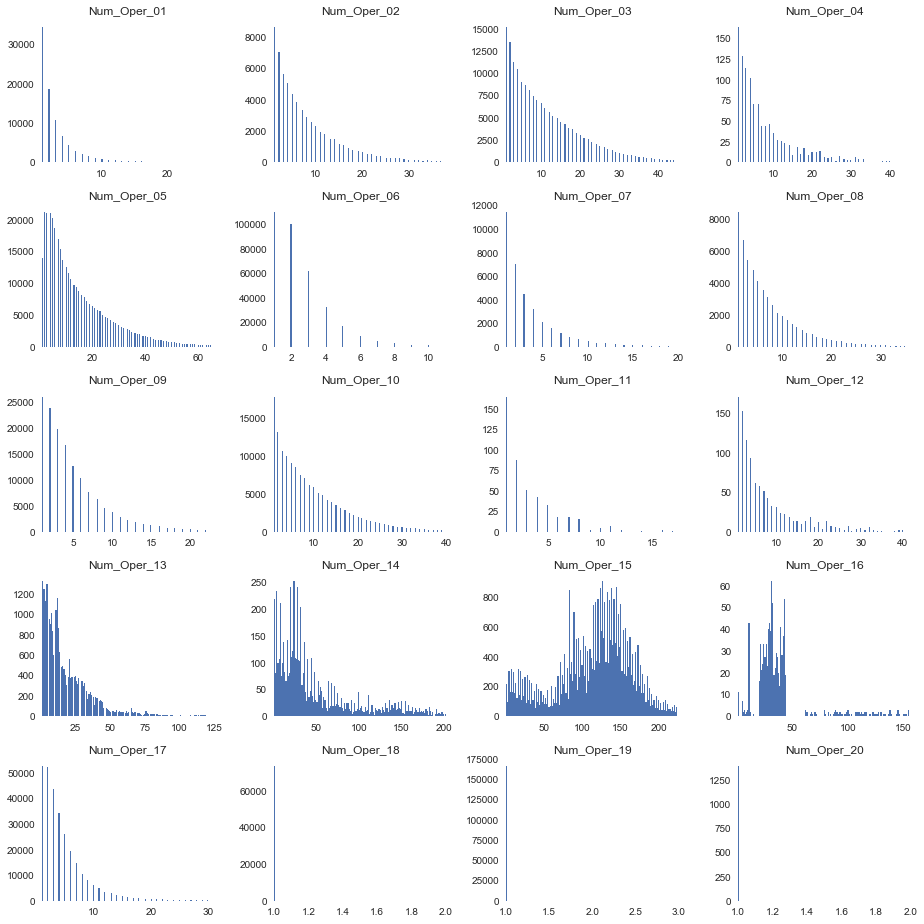

In [32]:
fig, axes = plt.subplots(5,4, figsize=(13,13), sharex=False)
axes = axes.flatten()
for ax, catplot in zip(axes, Num_Opers.columns):
    train_subplot = Num_Opers[Num_Opers[catplot] != 0]
    g = train_subplot[catplot][train_subplot[catplot] < np.percentile(train_subplot[catplot], 99)].hist(bins = 150, ax=ax)
    g.set(facecolor = "white")
    ax.set_xlim(xmin = train_subplot[catplot].min(), xmax=np.percentile(train_subplot[catplot], 99))
    ax.set_title(catplot)
plt.tight_layout()  
plt.show()

#### 2.7 Correlaciones con el poder adquisitivo </h3>

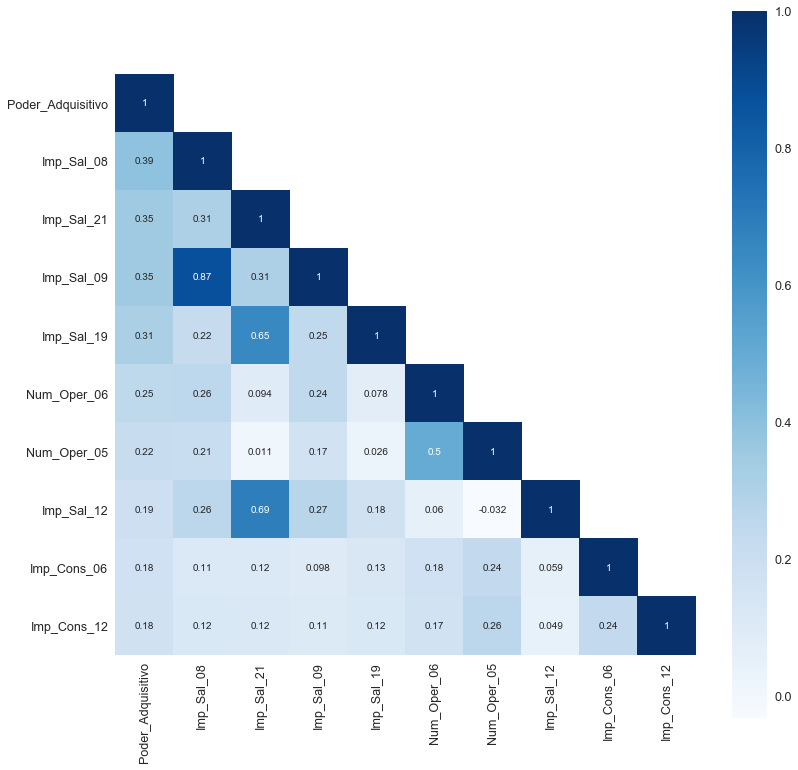

In [33]:
corr = df.corr()
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'Poder_Adquisitivo')['Poder_Adquisitivo'].index
mask = np.zeros_like(df[list(cols.values)].corr())
mask[np.triu_indices_from(mask, k=1)] = True
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (13,13))
    hm = sns.heatmap(cm, mask=mask, annot=True, square=True, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap='Blues')
    plt.show()

Esta matriz de correlación nos está dando una visión de qué variables están más correlacionadas con el poder adquisitivo. Vemos que, las variables que más correlación muestran con la variable dependiente son algunos de los importes de saldos de distintos productos. En especial el 8 y 9, los cuales no es de sorprender que tengan valores similares de correlación debido a que también están altamente correlacionados entre sí. Y vemos también que el número de operaciones 5 y 6 también muestran cierta correlación, por lo que presumiblemente también serán importantes para el modelo.

También hemos probamos de añadir nuevas variables cogiendo la suma, media, desviación estándar, etc de los grupos de las variables numéricas de Imp_Cons e Imp_Sal. Por otra parte, probamos de hacer un k-means de 10 y 11 clústers  de dichas variables respectivamente. Elejimos estas k's despúes de una evaluación de la curva Elbow. 

Finalmente, no usamos ninguna de estas variables ya que no ayudaban al modelo.

### 3. Manipulación de variables

In [34]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import pickle
import operator
import xgboost as xgb

In [35]:
path = "data/"
train_filename = "Dataset_Salesforce_Predictive_Modelling_TRAIN.txt"
df = pd.read_csv(path+train_filename,low_memory=False)

#Remplazamos un valor hexadecimal en la variable categórica Socio_Demo_01 por su correspondiente decimal
#para que no de problemas de tipo de datos luego.
df["Socio_Demo_01"].replace(to_replace='0X301', value=769, inplace=True)
df["Socio_Demo_01"] = df["Socio_Demo_01"].astype(np.float64)

A partir de los insights encontrados en el análisis exploratorio, aplicamos las siguientes manipulaciones de variables:
- Drop de variables no relevantes para el modelo
- Drop de usuarios cuyo poder adquisitivo es mayor que el percentil 99.9%
- Conversión de "2" a "1" en productos (excepto producto 24)
- Normalización de variables numéricas
- OneHot Encoding de variables catégoricas no binarias
- Conversión logarítmica del poder adquisitivo
- Buckets para la variable Socio_Demo_01 en función de su relación con el poder adquisitivo
- Creación de variables comentadas en la sección anterior

In [36]:
# NA
print (df.shape)
df = df.dropna().reset_index(drop = True)
print ("Duplicated: "+str(np.any(df.duplicated().values)))
print (df.shape)

(363834, 89)
Duplicated: False
(363224, 89)


In [37]:
# Outliers
print (df.shape)
df = df[df['Poder_Adquisitivo'] < np.percentile(df['Poder_Adquisitivo'], 99.9)]
print (df.shape)

(363224, 89)
(362860, 89)


En un primer momento, realizamos un split temporal para calcular los buckets de la variable Socio_Demo_01 sobre el futuro conjunto de train unicamente; calculando estos buckets sin usar el futuro conjunto de test.

In [38]:
df_train_temp, df_test_temp, y_train_temp, y_test_temp = train_test_split(df, df["Poder_Adquisitivo"].values, random_state=44)

In [39]:
# Función auxiliar para generar buckets de Socio_Demo_01 usuada durante el análisis exploratorio
def buckets(df):

    sumation_SD1 = df.Poder_Adquisitivo.groupby(df.Socio_Demo_01).sum()
    count_SD1 = df.Poder_Adquisitivo.groupby(df.Socio_Demo_01).count()
    avg_sum_SD1 = sumation_SD1/count_SD1

    temp = avg_sum_SD1.argsort().reset_index()
    bucket_1 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[-30:]
    bucket_2 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[-100:-30]
    bucket_3 = temp.loc[temp.Poder_Adquisitivo,:].Socio_Demo_01.values[:100]
    bucket_others = np.setdiff1d(np.unique(df_train_temp["Socio_Demo_01"].values), np.append(np.append(bucket_1,bucket_2),bucket_3))
    return bucket_1,bucket_2,bucket_3,bucket_others

bucket_1,bucket_2,bucket_3,bucket_others = buckets(df_train_temp)

Reproducimos el split anterior con 2/3 para el conjunto de train y 1/3 para el conjunto de test, ya de manera definitiva, con el mismo random_state anterior. 

In [40]:
#Labels con transformacion logaritmica
y = np.log(df["Poder_Adquisitivo"].values)
print(y.shape)

#Dataset principal sin labels
X = df.drop("Poder_Adquisitivo", axis = 1)
print(X.shape)

#Split 2/3 y 1/3
df_train, df_test, y_train, y_test = train_test_split(X, y, random_state=44)

(362860,)
(362860, 88)


Detallamos los grupos de variables que usaremos en el modelo.

In [41]:
categorical = np.array([u'Ind_Prod_01', u'Ind_Prod_02',
       u'Ind_Prod_03', u'Ind_Prod_04', u'Ind_Prod_05', u'Ind_Prod_06',
       u'Ind_Prod_07', u'Ind_Prod_08', u'Ind_Prod_09', u'Ind_Prod_10',
       u'Ind_Prod_11', u'Ind_Prod_12', u'Ind_Prod_13', u'Ind_Prod_14',
       u'Ind_Prod_15', u'Ind_Prod_16', u'Ind_Prod_17', u'Ind_Prod_18',
       u'Ind_Prod_19', u'Ind_Prod_20', u'Ind_Prod_21', u'Ind_Prod_22',
       u'Ind_Prod_23',"Socio_Demo_02"])

categorical_to_onehot = np.array(['Ind_Prod_24',"Socio_Demo_01"])

numerical = np.array([u'Imp_Cons_01', u'Imp_Cons_02', u'Imp_Cons_03',
       u'Imp_Cons_04', u'Imp_Cons_05', u'Imp_Cons_06', u'Imp_Cons_07',
       u'Imp_Cons_08', u'Imp_Cons_09', u'Imp_Cons_10', u'Imp_Cons_11',
       u'Imp_Cons_12', u'Imp_Cons_13', u'Imp_Cons_14', u'Imp_Cons_15',
       u'Imp_Cons_16', u'Imp_Cons_17', u'Imp_Sal_02',
       u'Imp_Sal_04', u'Imp_Sal_05', u'Imp_Sal_06',
       u'Imp_Sal_07', u'Imp_Sal_08', u'Imp_Sal_09', u'Imp_Sal_10',
       u'Imp_Sal_12', u'Imp_Sal_13', u'Imp_Sal_15',
       u'Imp_Sal_16', u'Imp_Sal_18', u'Imp_Sal_19',
       u'Imp_Sal_21', u'Num_Oper_01', u'Num_Oper_02',
       u'Num_Oper_03', u'Num_Oper_05', u'Num_Oper_06',
       u'Num_Oper_07', u'Num_Oper_08', u'Num_Oper_09', u'Num_Oper_10',
       u'Num_Oper_13', u'Num_Oper_14',
       u'Num_Oper_15', u'Num_Oper_17', u'Num_Oper_18',
       u'Num_Oper_19', u'Socio_Demo_03',
       u'Socio_Demo_04', u'Socio_Demo_05'])

Aplicamos las transformaciones mencionadas, sobre ambos conjuntos. La función siguiente devuelve matrices numpy en formato sparse, lo que incrementará la velocidad del modelo.

In [42]:
#Transformaciones
def transform(df,numerical,categorical,minmax,onehot,bucket_1,bucket_2,bucket_3,bucket_others, train = True):
    
    # Restamos 1 a la categórica socio_demo_02 para que tenga la forma 0,1 y no 1,2
    df.loc[:,"Socio_Demo_02"] = df.loc[:,"Socio_Demo_02"]-1
    
    # Remplazamos 2 por 1 en los productos con pocos 2
    for col in df.loc[:,'Ind_Prod_01':'Ind_Prod_23'].columns:
        df.loc[:,col] = df.loc[:,col].astype(int)
        df.loc[:,col].replace(to_replace=2, value=1, inplace=True)
    
    # Bucketing de Socio_Demo_01  
    df["Socio_Demo_01"].replace(to_replace = bucket_1, value = 1, inplace = True)
    df["Socio_Demo_01"].replace(to_replace = bucket_2, value = 2, inplace = True)
    df["Socio_Demo_01"].replace(to_replace = bucket_3, value = 3, inplace = True)
    df["Socio_Demo_01"].replace(to_replace = bucket_others, value = 0, inplace = True)
                            
    if train == True:
        #MinMax Scaling Fit de las features numéricas y OneHot Encoding Fit de las features 
        #a las que aplica, entrenadas en el conjunto de train unicamente
        minmax = MinMaxScaler()
        minmax.fit(df[numerical])

        onehot = OneHotEncoder()
        onehot.fit(df[categorical_to_onehot])
    
    #MinMax Scaling de las features numéricas y en sparse
    df_num_scaled = minmax.transform(df[numerical])
    df_num_sparse = sp.csr_matrix(df_num_scaled)  
    print ("Features Numéricas: "+str(df_num_sparse.shape[1]))
    
    # OneHot de features categoricas
    f_onehot_names = []
    for name in categorical_to_onehot:
        for i in range(len(df[name].unique())):
            aux = name + '_' + str(i)
            f_onehot_names.append(aux)
    df_cat_encoded = onehot.transform(df[categorical_to_onehot])
    print ("Features Categóricas sin OneHot encoding: "+str(df[categorical].shape[1]))
    print ("Features Categóricas con OneHot encoding: "+str(df_cat_encoded.shape[1]))
    
    # Concatenamos las matrices en formato sparse
    X = sp.hstack([df_num_sparse,sp.csr_matrix(df[categorical]),df_cat_encoded])
                                                         
    f_names = np.hstack([numerical,categorical,f_onehot_names])
    print ("Dataset: "+str(X.shape) )   
    return X, f_names, minmax, onehot

In [43]:
minmax = []
onehot = []
x_train, f_names, minmax1, onehot1 = transform(df_train,numerical,categorical,minmax,onehot,bucket_1,bucket_2,bucket_3,bucket_others)
x_test, trash1, trash2, trash3 = transform(df_test,numerical,categorical,minmax1,onehot1,bucket_1,bucket_2,bucket_3,bucket_others, train = False)

C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Features Numéricas: 50
Features Categóricas sin OneHot encoding: 24
Features Categóricas con OneHot encoding: 7
Dataset: (272145, 81)
Features Numéricas: 50
Features Categóricas sin OneHot encoding: 24
Features Categóricas con OneHot encoding: 7
Dataset: (90715, 81)


### 4. Modelo y ajuste de parámetros

Este problema estándar de aprendize supervisado para obtener una regresión puede plantearse con distintos modelos muy conocidos, desde una simple regresión linear, que planteamos a continuación a modo de baseline, hasta aplicar Random Forest, XGBoost, o Redes Neuronales, entre otras opciones. Tras probar un modelo Random Forest y una red neuronal de varias capas densas, optamos por el Extreme Gradient Boosting Regressor o XGBoost, un modelo que ha destacado durante los últimos anos en competiciones Kaggle, y con él que hemos obtenido mejores resultados. XGBoost clasifica ejemplos mediante el uso de un conjunto de árboles de decisión. Los árboles se construyen secuencialmente, añadiendo en cada iteración el árbol que mejor compense por los errores de los árboles ya existentes. Se le llama método de gradiente porque el modelo evoluciona en dirección al menor error, árbol a árbol.

Aplicamos un sencillo modelo de regresión linear como baseline.

In [44]:
LR = LinearRegression()
LR.fit(x_train,y_train)
y_pred = LR.predict(x_test)

# Evaluacion: Mean Absolute Error
def mae(true, pred):
    y_diff = np.absolute(true - pred)
    print ("MAE: " + str(np.mean(y_diff)))
    
mae(np.exp(y_test), np.exp(y_pred))

MAE: 43806.64427882638


Se obtiene un error absoluto medio cercano a los 5600€, sabiendo que el promedio de poder adquisitivo es de 16000€ y la mediana de 13000€. Utilizamos esta regresión linear como característica de entrada al modelo XGBoost ya que mejorará su capacidad predictora.

In [45]:
LR = LinearRegression()
LR.fit(x_train,y_train)
lr_train = pd.DataFrame(data=LR.predict(x_train),columns = ["lr"])
lr_test = pd.DataFrame(data=LR.predict(x_test),columns = ["lr"])
print (lr_train.shape)
print (lr_test.shape)
x_train = sp.hstack([x_train,lr_train])
x_test = sp.hstack([x_test,lr_test])

(272145, 1)
(90715, 1)


XGBoost posee varios hyperparámetros que deben ser tuneados para encontrar la combinación de aquellos que conducen al menor error absoluto medio: este proceso se denomina Grid Search. Lo ejecutamos a continuación, además de una validación cruzada (cross validation) para asegurarnos una correcta generalización del resultado. Además, utilizamos Early Stopping de Gradient Descent para evitar overfitting.

En la celda siguiente lanzamos un Grid Search de ejemplo, ya con los mejores parámetros obtenidos en una ejecucción anterior, para que la presente ejecucción no tarde demasiado.

In [46]:
#Grid Search original
paramGrid = {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [15,20,25], 'min_child_weight':[3,5], 
          'gamma': [0.3,1,3], 'subsample':[0.75], 'colsample_bytree':[0.75], 
          'n_estimators': [2000]}

#Grid Search Best Parameters (Comentar la linea siguiente en caso de querer 
#ejecutar el Grid Search original)
paramGrid = {'learning_rate': [0.01], 'max_depth': [25], 'min_child_weight':[3], 
          'gamma': [0.3], 'subsample':[0.75], 'colsample_bytree':[0.75], 
          'n_estimators': [1000]}

fit_params={"early_stopping_rounds": 20, 
            "eval_metric" : "mae", 
            "eval_set" : [[x_test, y_test]]}

cv = 5
model = xgb.XGBRegressor(nthread=-1)
grid = GridSearchCV(model, paramGrid, scoring = 'neg_mean_absolute_error', verbose=3,
         fit_params=fit_params,
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([x_train,y_train]))
grid.fit(x_train,y_train)
print (grid.best_params_)

C:\Users\jaume.puigbo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] colsample_bytree=0.75, gamma=0.3, learning_rate=0.01, max_depth=25, min_child_weight=3, n_estimators=1000, subsample=0.75 
[0]	validation_0-mae:8.90392
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.81491
[2]	validation_0-mae:8.72677
[3]	validation_0-mae:8.63953
[4]	validation_0-mae:8.55314
[5]	validation_0-mae:8.46762
[6]	validation_0-mae:8.38296
[7]	validation_0-mae:8.29914
[8]	validation_0-mae:8.21617
[9]	validation_0-mae:8.13405
[10]	validation_0-mae:8.05272
[11]	validation_0-mae:7.97222
[12]	validation_0-mae:7.89253
[13]	validation_0-mae:7.81362
[14]	validation_0-mae:7.7355
[15]	validation_0-mae:7.65817
[16]	validation_0-mae:7.5816
[17]	validation_0-mae:7.5058
[18]	validation_0-mae:7.43077
[19]	validation_0-mae:7.35648
[20]	validation_0-mae:7.28294
[21]	validation_0-mae:7.21011
[22]	validation_0-mae:7.13803
[23]	validation_0-mae:7.06666
[24]	validation_0-mae:6.99602
[25]	validat

[260]	validation_0-mae:0.670195
[261]	validation_0-mae:0.664102
[262]	validation_0-mae:0.658084
[263]	validation_0-mae:0.65211
[264]	validation_0-mae:0.646225
[265]	validation_0-mae:0.640408
[266]	validation_0-mae:0.634654
[267]	validation_0-mae:0.628951
[268]	validation_0-mae:0.623325
[269]	validation_0-mae:0.617772
[270]	validation_0-mae:0.6123
[271]	validation_0-mae:0.606904
[272]	validation_0-mae:0.601567
[273]	validation_0-mae:0.596276
[274]	validation_0-mae:0.591081
[275]	validation_0-mae:0.585926
[276]	validation_0-mae:0.580834
[277]	validation_0-mae:0.575812
[278]	validation_0-mae:0.570848
[279]	validation_0-mae:0.565961
[280]	validation_0-mae:0.561113
[281]	validation_0-mae:0.556333
[282]	validation_0-mae:0.551604
[283]	validation_0-mae:0.546923
[284]	validation_0-mae:0.542307
[285]	validation_0-mae:0.537749
[286]	validation_0-mae:0.533243
[287]	validation_0-mae:0.528812
[288]	validation_0-mae:0.524437
[289]	validation_0-mae:0.52011
[290]	validation_0-mae:0.515828
[291]	valida

[518]	validation_0-mae:0.230386
[519]	validation_0-mae:0.230273
[520]	validation_0-mae:0.230156
[521]	validation_0-mae:0.230042
[522]	validation_0-mae:0.229933
[523]	validation_0-mae:0.229822
[524]	validation_0-mae:0.229717
[525]	validation_0-mae:0.229616
[526]	validation_0-mae:0.229508
[527]	validation_0-mae:0.229413
[528]	validation_0-mae:0.229308
[529]	validation_0-mae:0.229215
[530]	validation_0-mae:0.229122
[531]	validation_0-mae:0.229022
[532]	validation_0-mae:0.228924
[533]	validation_0-mae:0.22882
[534]	validation_0-mae:0.228731
[535]	validation_0-mae:0.228644
[536]	validation_0-mae:0.228549
[537]	validation_0-mae:0.228466
[538]	validation_0-mae:0.228376
[539]	validation_0-mae:0.228297
[540]	validation_0-mae:0.228216
[541]	validation_0-mae:0.228136
[542]	validation_0-mae:0.228058
[543]	validation_0-mae:0.22798
[544]	validation_0-mae:0.227906
[545]	validation_0-mae:0.227825
[546]	validation_0-mae:0.22775
[547]	validation_0-mae:0.227674
[548]	validation_0-mae:0.227601
[549]	valid

[775]	validation_0-mae:0.223174
[776]	validation_0-mae:0.223171
[777]	validation_0-mae:0.223169
[778]	validation_0-mae:0.223165
[779]	validation_0-mae:0.223156
[780]	validation_0-mae:0.223155
[781]	validation_0-mae:0.223152
[782]	validation_0-mae:0.223147
[783]	validation_0-mae:0.22314
[784]	validation_0-mae:0.223137
[785]	validation_0-mae:0.223134
[786]	validation_0-mae:0.223129
[787]	validation_0-mae:0.223126
[788]	validation_0-mae:0.223124
[789]	validation_0-mae:0.223122
[790]	validation_0-mae:0.22312
[791]	validation_0-mae:0.223119
[792]	validation_0-mae:0.223118
[793]	validation_0-mae:0.223114
[794]	validation_0-mae:0.223111
[795]	validation_0-mae:0.223109
[796]	validation_0-mae:0.223107
[797]	validation_0-mae:0.223102
[798]	validation_0-mae:0.223095
[799]	validation_0-mae:0.223093
[800]	validation_0-mae:0.223091
[801]	validation_0-mae:0.223087
[802]	validation_0-mae:0.223084
[803]	validation_0-mae:0.223081
[804]	validation_0-mae:0.223079
[805]	validation_0-mae:0.223076
[806]	vali

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.9min remaining:    0.0s


[0]	validation_0-mae:8.90392
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.81492
[2]	validation_0-mae:8.72679
[3]	validation_0-mae:8.63954
[4]	validation_0-mae:8.55316
[5]	validation_0-mae:8.46764
[6]	validation_0-mae:8.38299
[7]	validation_0-mae:8.29917
[8]	validation_0-mae:8.2162
[9]	validation_0-mae:8.13407
[10]	validation_0-mae:8.05277
[11]	validation_0-mae:7.97227
[12]	validation_0-mae:7.89258
[13]	validation_0-mae:7.81368
[14]	validation_0-mae:7.73555
[15]	validation_0-mae:7.65823
[16]	validation_0-mae:7.58167
[17]	validation_0-mae:7.50587
[18]	validation_0-mae:7.43083
[19]	validation_0-mae:7.35655
[20]	validation_0-mae:7.28301
[21]	validation_0-mae:7.21019
[22]	validation_0-mae:7.13811
[23]	validation_0-mae:7.06676
[24]	validation_0-mae:6.99612
[25]	validation_0-mae:6.92619
[26]	validation_0-mae:6.85695
[27]	validation_0-mae:6.78841
[28]	validation_0-mae:6.72056
[29]	validation_0-mae:6.65339
[30]	validation_0-mae:6.58688
[31]	validation_0

[266]	validation_0-mae:0.635065
[267]	validation_0-mae:0.629383
[268]	validation_0-mae:0.623769
[269]	validation_0-mae:0.618234
[270]	validation_0-mae:0.612743
[271]	validation_0-mae:0.607335
[272]	validation_0-mae:0.602
[273]	validation_0-mae:0.596706
[274]	validation_0-mae:0.591494
[275]	validation_0-mae:0.586346
[276]	validation_0-mae:0.58126
[277]	validation_0-mae:0.576237
[278]	validation_0-mae:0.571263
[279]	validation_0-mae:0.566374
[280]	validation_0-mae:0.561526
[281]	validation_0-mae:0.556747
[282]	validation_0-mae:0.552026
[283]	validation_0-mae:0.547357
[284]	validation_0-mae:0.542746
[285]	validation_0-mae:0.538195
[286]	validation_0-mae:0.533698
[287]	validation_0-mae:0.529263
[288]	validation_0-mae:0.524881
[289]	validation_0-mae:0.520558
[290]	validation_0-mae:0.516278
[291]	validation_0-mae:0.512056
[292]	validation_0-mae:0.507887
[293]	validation_0-mae:0.503758
[294]	validation_0-mae:0.49969
[295]	validation_0-mae:0.495676
[296]	validation_0-mae:0.491709
[297]	validat

[524]	validation_0-mae:0.229824
[525]	validation_0-mae:0.229719
[526]	validation_0-mae:0.229612
[527]	validation_0-mae:0.229508
[528]	validation_0-mae:0.229413
[529]	validation_0-mae:0.229317
[530]	validation_0-mae:0.229226
[531]	validation_0-mae:0.229125
[532]	validation_0-mae:0.229028
[533]	validation_0-mae:0.228932
[534]	validation_0-mae:0.228841
[535]	validation_0-mae:0.228755
[536]	validation_0-mae:0.228667
[537]	validation_0-mae:0.228579
[538]	validation_0-mae:0.228492
[539]	validation_0-mae:0.228412
[540]	validation_0-mae:0.228332
[541]	validation_0-mae:0.228253
[542]	validation_0-mae:0.228175
[543]	validation_0-mae:0.228096
[544]	validation_0-mae:0.228025
[545]	validation_0-mae:0.227948
[546]	validation_0-mae:0.227867
[547]	validation_0-mae:0.227795
[548]	validation_0-mae:0.227724
[549]	validation_0-mae:0.227652
[550]	validation_0-mae:0.227586
[551]	validation_0-mae:0.22752
[552]	validation_0-mae:0.227452
[553]	validation_0-mae:0.227384
[554]	validation_0-mae:0.227316
[555]	val

[781]	validation_0-mae:0.223243
[782]	validation_0-mae:0.223235
[783]	validation_0-mae:0.223233
[784]	validation_0-mae:0.22323
[785]	validation_0-mae:0.223227
[786]	validation_0-mae:0.223222
[787]	validation_0-mae:0.223218
[788]	validation_0-mae:0.223213
[789]	validation_0-mae:0.223212
[790]	validation_0-mae:0.223211
[791]	validation_0-mae:0.223208
[792]	validation_0-mae:0.223205
[793]	validation_0-mae:0.223202
[794]	validation_0-mae:0.2232
[795]	validation_0-mae:0.223196
[796]	validation_0-mae:0.223194
[797]	validation_0-mae:0.223192
[798]	validation_0-mae:0.223184
[799]	validation_0-mae:0.223182
[800]	validation_0-mae:0.223178
[801]	validation_0-mae:0.223175
[802]	validation_0-mae:0.223171
[803]	validation_0-mae:0.223163
[804]	validation_0-mae:0.223161
[805]	validation_0-mae:0.22316
[806]	validation_0-mae:0.223156
[807]	validation_0-mae:0.223153
[808]	validation_0-mae:0.223147
[809]	validation_0-mae:0.223146
[810]	validation_0-mae:0.223143
[811]	validation_0-mae:0.223141
[812]	valida

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 59.9min remaining:    0.0s


[0]	validation_0-mae:8.90391
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.81491
[2]	validation_0-mae:8.72679
[3]	validation_0-mae:8.63954
[4]	validation_0-mae:8.55316
[5]	validation_0-mae:8.46765
[6]	validation_0-mae:8.38299
[7]	validation_0-mae:8.29918
[8]	validation_0-mae:8.2162
[9]	validation_0-mae:8.13407
[10]	validation_0-mae:8.05276
[11]	validation_0-mae:7.97225
[12]	validation_0-mae:7.89256
[13]	validation_0-mae:7.81365
[14]	validation_0-mae:7.73553
[15]	validation_0-mae:7.6582
[16]	validation_0-mae:7.58164
[17]	validation_0-mae:7.50584
[18]	validation_0-mae:7.4308
[19]	validation_0-mae:7.35651
[20]	validation_0-mae:7.28296
[21]	validation_0-mae:7.21014
[22]	validation_0-mae:7.13807
[23]	validation_0-mae:7.06671
[24]	validation_0-mae:6.99608
[25]	validation_0-mae:6.92614
[26]	validation_0-mae:6.8569
[27]	validation_0-mae:6.78835
[28]	validation_0-mae:6.72049
[29]	validation_0-mae:6.65332
[30]	validation_0-mae:6.58681
[31]	validation_0-ma

[266]	validation_0-mae:0.634945
[267]	validation_0-mae:0.629257
[268]	validation_0-mae:0.62364
[269]	validation_0-mae:0.618098
[270]	validation_0-mae:0.612611
[271]	validation_0-mae:0.607209
[272]	validation_0-mae:0.60187
[273]	validation_0-mae:0.596581
[274]	validation_0-mae:0.591381
[275]	validation_0-mae:0.586233
[276]	validation_0-mae:0.581144
[277]	validation_0-mae:0.576116
[278]	validation_0-mae:0.571141
[279]	validation_0-mae:0.566248
[280]	validation_0-mae:0.561395
[281]	validation_0-mae:0.556617
[282]	validation_0-mae:0.551887
[283]	validation_0-mae:0.547221
[284]	validation_0-mae:0.542604
[285]	validation_0-mae:0.538051
[286]	validation_0-mae:0.533553
[287]	validation_0-mae:0.529113
[288]	validation_0-mae:0.524731
[289]	validation_0-mae:0.520409
[290]	validation_0-mae:0.516139
[291]	validation_0-mae:0.511919
[292]	validation_0-mae:0.507738
[293]	validation_0-mae:0.503617
[294]	validation_0-mae:0.499559
[295]	validation_0-mae:0.495539
[296]	validation_0-mae:0.491569
[297]	vali

[523]	validation_0-mae:0.2299
[524]	validation_0-mae:0.229794
[525]	validation_0-mae:0.229689
[526]	validation_0-mae:0.229582
[527]	validation_0-mae:0.229481
[528]	validation_0-mae:0.22938
[529]	validation_0-mae:0.22928
[530]	validation_0-mae:0.229183
[531]	validation_0-mae:0.229082
[532]	validation_0-mae:0.228991
[533]	validation_0-mae:0.2289
[534]	validation_0-mae:0.228809
[535]	validation_0-mae:0.228723
[536]	validation_0-mae:0.228631
[537]	validation_0-mae:0.228545
[538]	validation_0-mae:0.228457
[539]	validation_0-mae:0.228376
[540]	validation_0-mae:0.228298
[541]	validation_0-mae:0.228217
[542]	validation_0-mae:0.228132
[543]	validation_0-mae:0.228056
[544]	validation_0-mae:0.227975
[545]	validation_0-mae:0.227894
[546]	validation_0-mae:0.227811
[547]	validation_0-mae:0.227738
[548]	validation_0-mae:0.227668
[549]	validation_0-mae:0.227597
[550]	validation_0-mae:0.22753
[551]	validation_0-mae:0.227465
[552]	validation_0-mae:0.227396
[553]	validation_0-mae:0.227331
[554]	validatio

[781]	validation_0-mae:0.223171
[782]	validation_0-mae:0.223164
[783]	validation_0-mae:0.223161
[784]	validation_0-mae:0.223157
[785]	validation_0-mae:0.223152
[786]	validation_0-mae:0.223148
[787]	validation_0-mae:0.22314
[788]	validation_0-mae:0.223132
[789]	validation_0-mae:0.223128
[790]	validation_0-mae:0.223122
[791]	validation_0-mae:0.22312
[792]	validation_0-mae:0.223118
[793]	validation_0-mae:0.223112
[794]	validation_0-mae:0.223109
[795]	validation_0-mae:0.223105
[796]	validation_0-mae:0.223098
[797]	validation_0-mae:0.223094
[798]	validation_0-mae:0.223091
[799]	validation_0-mae:0.223089
[800]	validation_0-mae:0.223085
[801]	validation_0-mae:0.223081
[802]	validation_0-mae:0.223078
[803]	validation_0-mae:0.223073
[804]	validation_0-mae:0.223071
[805]	validation_0-mae:0.223068
[806]	validation_0-mae:0.223065
[807]	validation_0-mae:0.223062
[808]	validation_0-mae:0.22306
[809]	validation_0-mae:0.223058
[810]	validation_0-mae:0.223054
[811]	validation_0-mae:0.223052
[812]	valid

[29]	validation_0-mae:6.65339
[30]	validation_0-mae:6.58687
[31]	validation_0-mae:6.52102
[32]	validation_0-mae:6.45584
[33]	validation_0-mae:6.3913
[34]	validation_0-mae:6.3274
[35]	validation_0-mae:6.26415
[36]	validation_0-mae:6.20154
[37]	validation_0-mae:6.13955
[38]	validation_0-mae:6.07818
[39]	validation_0-mae:6.01742
[40]	validation_0-mae:5.95728
[41]	validation_0-mae:5.89773
[42]	validation_0-mae:5.83878
[43]	validation_0-mae:5.78041
[44]	validation_0-mae:5.72264
[45]	validation_0-mae:5.66543
[46]	validation_0-mae:5.6088
[47]	validation_0-mae:5.55274
[48]	validation_0-mae:5.49723
[49]	validation_0-mae:5.44229
[50]	validation_0-mae:5.38788
[51]	validation_0-mae:5.33402
[52]	validation_0-mae:5.2807
[53]	validation_0-mae:5.22792
[54]	validation_0-mae:5.17566
[55]	validation_0-mae:5.12393
[56]	validation_0-mae:5.07272
[57]	validation_0-mae:5.02202
[58]	validation_0-mae:4.97183
[59]	validation_0-mae:4.92213
[60]	validation_0-mae:4.87294
[61]	validation_0-mae:4.82423
[62]	validatio

[295]	validation_0-mae:0.495629
[296]	validation_0-mae:0.491654
[297]	validation_0-mae:0.487754
[298]	validation_0-mae:0.483896
[299]	validation_0-mae:0.480082
[300]	validation_0-mae:0.476325
[301]	validation_0-mae:0.47261
[302]	validation_0-mae:0.46895
[303]	validation_0-mae:0.46534
[304]	validation_0-mae:0.461765
[305]	validation_0-mae:0.458237
[306]	validation_0-mae:0.454757
[307]	validation_0-mae:0.451327
[308]	validation_0-mae:0.447924
[309]	validation_0-mae:0.444585
[310]	validation_0-mae:0.441299
[311]	validation_0-mae:0.438036
[312]	validation_0-mae:0.434826
[313]	validation_0-mae:0.431647
[314]	validation_0-mae:0.428519
[315]	validation_0-mae:0.425429
[316]	validation_0-mae:0.422365
[317]	validation_0-mae:0.419356
[318]	validation_0-mae:0.416398
[319]	validation_0-mae:0.413478
[320]	validation_0-mae:0.410592
[321]	validation_0-mae:0.40775
[322]	validation_0-mae:0.404937
[323]	validation_0-mae:0.402186
[324]	validation_0-mae:0.39946
[325]	validation_0-mae:0.39678
[326]	validati

[552]	validation_0-mae:0.227463
[553]	validation_0-mae:0.227397
[554]	validation_0-mae:0.227329
[555]	validation_0-mae:0.227269
[556]	validation_0-mae:0.227207
[557]	validation_0-mae:0.227144
[558]	validation_0-mae:0.227083
[559]	validation_0-mae:0.227028
[560]	validation_0-mae:0.226968
[561]	validation_0-mae:0.22691
[562]	validation_0-mae:0.226857
[563]	validation_0-mae:0.226802
[564]	validation_0-mae:0.226749
[565]	validation_0-mae:0.226695
[566]	validation_0-mae:0.226641
[567]	validation_0-mae:0.226591
[568]	validation_0-mae:0.226541
[569]	validation_0-mae:0.226489
[570]	validation_0-mae:0.22644
[571]	validation_0-mae:0.226393
[572]	validation_0-mae:0.226343
[573]	validation_0-mae:0.226299
[574]	validation_0-mae:0.226256
[575]	validation_0-mae:0.226207
[576]	validation_0-mae:0.226164
[577]	validation_0-mae:0.226119
[578]	validation_0-mae:0.226075
[579]	validation_0-mae:0.226033
[580]	validation_0-mae:0.225993
[581]	validation_0-mae:0.22595
[582]	validation_0-mae:0.225913
[583]	valid

[809]	validation_0-mae:0.223164
[810]	validation_0-mae:0.223162
[811]	validation_0-mae:0.223159
[812]	validation_0-mae:0.223157
[813]	validation_0-mae:0.223155
[814]	validation_0-mae:0.22315
[815]	validation_0-mae:0.223147
[816]	validation_0-mae:0.223144
[817]	validation_0-mae:0.223143
[818]	validation_0-mae:0.22314
[819]	validation_0-mae:0.223138
[820]	validation_0-mae:0.223137
[821]	validation_0-mae:0.223133
[822]	validation_0-mae:0.22313
[823]	validation_0-mae:0.223131
[824]	validation_0-mae:0.223129
[825]	validation_0-mae:0.223123
[826]	validation_0-mae:0.223122
[827]	validation_0-mae:0.22312
[828]	validation_0-mae:0.223117
[829]	validation_0-mae:0.223115
[830]	validation_0-mae:0.223113
[831]	validation_0-mae:0.22311
[832]	validation_0-mae:0.223104
[833]	validation_0-mae:0.223102
[834]	validation_0-mae:0.2231
[835]	validation_0-mae:0.223098
[836]	validation_0-mae:0.223097
[837]	validation_0-mae:0.223097
[838]	validation_0-mae:0.22309
[839]	validation_0-mae:0.223087
[840]	validation

[59]	validation_0-mae:4.92213
[60]	validation_0-mae:4.87294
[61]	validation_0-mae:4.82424
[62]	validation_0-mae:4.77603
[63]	validation_0-mae:4.7283
[64]	validation_0-mae:4.68104
[65]	validation_0-mae:4.63426
[66]	validation_0-mae:4.58794
[67]	validation_0-mae:4.54209
[68]	validation_0-mae:4.49671
[69]	validation_0-mae:4.45177
[70]	validation_0-mae:4.40728
[71]	validation_0-mae:4.36323
[72]	validation_0-mae:4.31962
[73]	validation_0-mae:4.27645
[74]	validation_0-mae:4.23371
[75]	validation_0-mae:4.1914
[76]	validation_0-mae:4.14951
[77]	validation_0-mae:4.10803
[78]	validation_0-mae:4.06698
[79]	validation_0-mae:4.02633
[80]	validation_0-mae:3.98609
[81]	validation_0-mae:3.94626
[82]	validation_0-mae:3.90683
[83]	validation_0-mae:3.86779
[84]	validation_0-mae:3.82913
[85]	validation_0-mae:3.79086
[86]	validation_0-mae:3.75298
[87]	validation_0-mae:3.71548
[88]	validation_0-mae:3.67835
[89]	validation_0-mae:3.6416
[90]	validation_0-mae:3.60521
[91]	validation_0-mae:3.56919
[92]	validati

[323]	validation_0-mae:0.402212
[324]	validation_0-mae:0.399493
[325]	validation_0-mae:0.396813
[326]	validation_0-mae:0.394157
[327]	validation_0-mae:0.391552
[328]	validation_0-mae:0.388976
[329]	validation_0-mae:0.386437
[330]	validation_0-mae:0.383931
[331]	validation_0-mae:0.381463
[332]	validation_0-mae:0.379032
[333]	validation_0-mae:0.376628
[334]	validation_0-mae:0.374254
[335]	validation_0-mae:0.371913
[336]	validation_0-mae:0.36962
[337]	validation_0-mae:0.367355
[338]	validation_0-mae:0.365121
[339]	validation_0-mae:0.362926
[340]	validation_0-mae:0.360744
[341]	validation_0-mae:0.358605
[342]	validation_0-mae:0.356501
[343]	validation_0-mae:0.35442
[344]	validation_0-mae:0.352366
[345]	validation_0-mae:0.350353
[346]	validation_0-mae:0.348358
[347]	validation_0-mae:0.346389
[348]	validation_0-mae:0.344454
[349]	validation_0-mae:0.342553
[350]	validation_0-mae:0.340676
[351]	validation_0-mae:0.338823
[352]	validation_0-mae:0.336994
[353]	validation_0-mae:0.335192
[354]	vali

[580]	validation_0-mae:0.226302
[581]	validation_0-mae:0.226256
[582]	validation_0-mae:0.226217
[583]	validation_0-mae:0.226176
[584]	validation_0-mae:0.226138
[585]	validation_0-mae:0.226095
[586]	validation_0-mae:0.226059
[587]	validation_0-mae:0.226017
[588]	validation_0-mae:0.225976
[589]	validation_0-mae:0.225934
[590]	validation_0-mae:0.225899
[591]	validation_0-mae:0.225867
[592]	validation_0-mae:0.225828
[593]	validation_0-mae:0.225795
[594]	validation_0-mae:0.225758
[595]	validation_0-mae:0.225729
[596]	validation_0-mae:0.225696
[597]	validation_0-mae:0.225667
[598]	validation_0-mae:0.225633
[599]	validation_0-mae:0.225603
[600]	validation_0-mae:0.225574
[601]	validation_0-mae:0.225544
[602]	validation_0-mae:0.225514
[603]	validation_0-mae:0.225484
[604]	validation_0-mae:0.225454
[605]	validation_0-mae:0.225424
[606]	validation_0-mae:0.225392
[607]	validation_0-mae:0.225366
[608]	validation_0-mae:0.225339
[609]	validation_0-mae:0.225313
[610]	validation_0-mae:0.225287
[611]	va

[837]	validation_0-mae:0.223379
[838]	validation_0-mae:0.223369
[839]	validation_0-mae:0.223366
[840]	validation_0-mae:0.223362
[841]	validation_0-mae:0.223361
[842]	validation_0-mae:0.223357
[843]	validation_0-mae:0.223356
[844]	validation_0-mae:0.22335
[845]	validation_0-mae:0.22335
[846]	validation_0-mae:0.223349
[847]	validation_0-mae:0.223348
[848]	validation_0-mae:0.223347
[849]	validation_0-mae:0.223344
[850]	validation_0-mae:0.223343
[851]	validation_0-mae:0.223341
[852]	validation_0-mae:0.223339
[853]	validation_0-mae:0.223337
[854]	validation_0-mae:0.223333
[855]	validation_0-mae:0.22333
[856]	validation_0-mae:0.223328
[857]	validation_0-mae:0.223327
[858]	validation_0-mae:0.223324
[859]	validation_0-mae:0.223323
[860]	validation_0-mae:0.223321
[861]	validation_0-mae:0.223316
[862]	validation_0-mae:0.223313
[863]	validation_0-mae:0.223312
[864]	validation_0-mae:0.223312
[865]	validation_0-mae:0.223309
[866]	validation_0-mae:0.223307
[867]	validation_0-mae:0.223306
[868]	valid

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 147.0min finished


[0]	validation_0-mae:8.90392
Will train until validation_0-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:8.8149
[2]	validation_0-mae:8.72678
[3]	validation_0-mae:8.63953
[4]	validation_0-mae:8.55316
[5]	validation_0-mae:8.46764
[6]	validation_0-mae:8.38299
[7]	validation_0-mae:8.29918
[8]	validation_0-mae:8.21621
[9]	validation_0-mae:8.13407
[10]	validation_0-mae:8.05274
[11]	validation_0-mae:7.97223
[12]	validation_0-mae:7.89252
[13]	validation_0-mae:7.81362
[14]	validation_0-mae:7.7355
[15]	validation_0-mae:7.65816
[16]	validation_0-mae:7.5816
[17]	validation_0-mae:7.5058
[18]	validation_0-mae:7.43077
[19]	validation_0-mae:7.35647
[20]	validation_0-mae:7.28293
[21]	validation_0-mae:7.21011
[22]	validation_0-mae:7.13803
[23]	validation_0-mae:7.06667
[24]	validation_0-mae:6.99602
[25]	validation_0-mae:6.92608
[26]	validation_0-mae:6.85685
[27]	validation_0-mae:6.7883
[28]	validation_0-mae:6.72044
[29]	validation_0-mae:6.65326
[30]	validation_0-mae:6.58674
[31]	validation_0-mae

[266]	validation_0-mae:0.634768
[267]	validation_0-mae:0.62909
[268]	validation_0-mae:0.623476
[269]	validation_0-mae:0.617942
[270]	validation_0-mae:0.61247
[271]	validation_0-mae:0.607055
[272]	validation_0-mae:0.601696
[273]	validation_0-mae:0.596397
[274]	validation_0-mae:0.59116
[275]	validation_0-mae:0.586
[276]	validation_0-mae:0.580903
[277]	validation_0-mae:0.575865
[278]	validation_0-mae:0.570898
[279]	validation_0-mae:0.56598
[280]	validation_0-mae:0.561126
[281]	validation_0-mae:0.556326
[282]	validation_0-mae:0.551606
[283]	validation_0-mae:0.546923
[284]	validation_0-mae:0.542304
[285]	validation_0-mae:0.537741
[286]	validation_0-mae:0.533236
[287]	validation_0-mae:0.528794
[288]	validation_0-mae:0.52441
[289]	validation_0-mae:0.520063
[290]	validation_0-mae:0.515778
[291]	validation_0-mae:0.511555
[292]	validation_0-mae:0.507378
[293]	validation_0-mae:0.50325
[294]	validation_0-mae:0.499184
[295]	validation_0-mae:0.495157
[296]	validation_0-mae:0.491191
[297]	validation_

[524]	validation_0-mae:0.229147
[525]	validation_0-mae:0.229039
[526]	validation_0-mae:0.22893
[527]	validation_0-mae:0.22883
[528]	validation_0-mae:0.228733
[529]	validation_0-mae:0.228638
[530]	validation_0-mae:0.228544
[531]	validation_0-mae:0.228451
[532]	validation_0-mae:0.22836
[533]	validation_0-mae:0.228269
[534]	validation_0-mae:0.22818
[535]	validation_0-mae:0.228087
[536]	validation_0-mae:0.227994
[537]	validation_0-mae:0.227905
[538]	validation_0-mae:0.227818
[539]	validation_0-mae:0.227729
[540]	validation_0-mae:0.227643
[541]	validation_0-mae:0.227556
[542]	validation_0-mae:0.227478
[543]	validation_0-mae:0.227401
[544]	validation_0-mae:0.227324
[545]	validation_0-mae:0.227251
[546]	validation_0-mae:0.227176
[547]	validation_0-mae:0.227104
[548]	validation_0-mae:0.227025
[549]	validation_0-mae:0.226956
[550]	validation_0-mae:0.22689
[551]	validation_0-mae:0.226817
[552]	validation_0-mae:0.22675
[553]	validation_0-mae:0.226685
[554]	validation_0-mae:0.226617
[555]	validati

[782]	validation_0-mae:0.222517
[783]	validation_0-mae:0.222512
[784]	validation_0-mae:0.222509
[785]	validation_0-mae:0.222506
[786]	validation_0-mae:0.222504
[787]	validation_0-mae:0.222502
[788]	validation_0-mae:0.222496
[789]	validation_0-mae:0.222492
[790]	validation_0-mae:0.222488
[791]	validation_0-mae:0.222485
[792]	validation_0-mae:0.222483
[793]	validation_0-mae:0.222477
[794]	validation_0-mae:0.222475
[795]	validation_0-mae:0.222472
[796]	validation_0-mae:0.222469
[797]	validation_0-mae:0.222468
[798]	validation_0-mae:0.222465
[799]	validation_0-mae:0.222461
[800]	validation_0-mae:0.222457
[801]	validation_0-mae:0.222451
[802]	validation_0-mae:0.222449
[803]	validation_0-mae:0.222445
[804]	validation_0-mae:0.222442
[805]	validation_0-mae:0.222441
[806]	validation_0-mae:0.222438
[807]	validation_0-mae:0.222432
[808]	validation_0-mae:0.222428
[809]	validation_0-mae:0.222428
[810]	validation_0-mae:0.222425
[811]	validation_0-mae:0.222421
[812]	validation_0-mae:0.222419
[813]	va

Sería conveniente explorar más combinaciones de parámetros para conseguir un ajuste aún más óptimo, pero tenemos ciertas limitaciones computacionales. Es un punto a considerar para productizar la solución.

El Grid Search genera los siguientes mejores parámetros:
* colsample_bytree: 0.75
* learning_rate: 0.01
* min_child_weight: 3
* n_estimators: 1000
* subsample: 0.75
* max_depth: 25
* gamma: 0.3
    

Guardamos el objeto Grid para posibles futuras operaciones.

In [47]:
pickle.dump(grid, open("grid.dat", "wb"))
#grid = pickle.load(open("grid.dat", "rb"))

### 5. Evaluación

Proponemos dos métricas para evaluar el error del modelo :

* Mean Absolute Error: $$MAE = \frac{1}{n} \sum_{i=1}^{n} \big|y_{real} - y_{pred}\big|$$

* Mean Absolute Percentage Error: $$MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{\big|y_{real} - y_{pred}\big|}{\big|y_{real}\big|}$$

donde $y_{real} \in \mathbb{R^n}$ son los valores reales, $y_{pred} \in \mathbb{R^n}$ son los valores de la predicción.

Nos hemos decido por estas métricas ya que son las más naturales para medir el error. El MAE está expresado en euros, mientras que el MAPE es un porcentaje de error. El MAPE puede ser más representativo al tener distintos órdenes de magnitud en la variable de poder adquisitivo.

Generamos las predicciones para su evaluación.

In [48]:
y_pred = grid.best_estimator_.predict(x_test)

MAE (100%): 3720.9109701831894


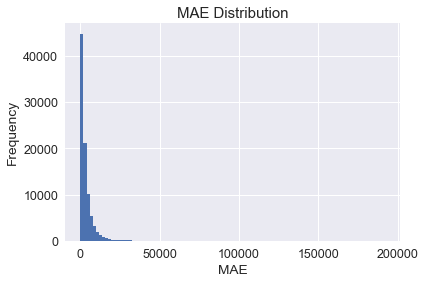

In [49]:
# MAE
def eval_mae(true, pred, q=1.0) :
    y_diff = np.absolute(true - pred)
    y_diff_q=pd.Series(y_diff)
    y_diff_q = y_diff_q[y_diff_q<y_diff_q.quantile(q)]
    mae = np.mean(y_diff_q)
    print ("MAE (" +str(int(q*100)) + "%): " + str(mae))
    plt.hist(y_diff_q, bins = 100)
    plt.title('MAE Distribution')
    plt.ylabel('Frequency')
    plt.xlabel('MAE')
    plt.show()
    return mae

mae_100 = eval_mae(np.exp(y_pred), np.exp(y_test))

Obtenemos un error medio de 3700 euros aproximadamente. Para ver mejor la distribución del error nos quedamos con aquellos errores que son inferior al percentil 0.95. De esta manera obtenemos un error medio de 2506 euros aproximadamente. Como podemos observar en la siguiente gráfica el 95% de los casos el error es menor a 12000 euros.

MAE (95%): 2597.168445038852


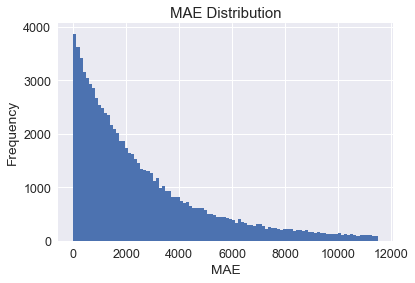

In [50]:
# MAE percentile 0.95
mae_95 = eval_mae(np.exp(y_pred), np.exp(y_test), q=0.95)

Veamos ahora los resultados del MAPE y veremos como obtenemos otra interpretación de los resultados.

MAPE (100%): 0.23723144583964734


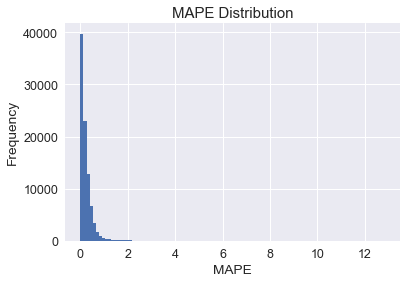

In [51]:
# MAPE
def eval_mape(true, pred, q=1.0) :
    mape = np.absolute(true - pred)/np.abs(true)
    y_diff_q=pd.Series(mape)
    y_diff_q = y_diff_q[y_diff_q<y_diff_q.quantile(q)]
    mape = np.mean(y_diff_q)
    print ("MAPE (" +str(int(q*100)) + "%): " + str(mape))
    plt.hist(y_diff_q, bins = 100)
    plt.title('MAPE Distribution')
    plt.ylabel('Frequency')
    plt.xlabel('MAPE')
    plt.show()
    return mape

mape_100 = eval_mape(np.exp(y_pred), np.exp(y_test))

Obtenemos un error medio de aproximadamente un 23%. Es decir, la predicción es un 23% mayor o menor respecto al valor real de media. Si nos fijamos en el 95% de los mejores casos obtenemos un MAPE de 18% aproximadamente y podemos ver que el 95% el error del 12000 euros se corresponde como máximo a menos del 70% de error.

MAPE (95%): 0.18416832150684748


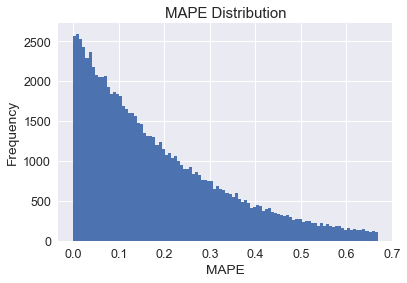

In [52]:
# MAPE percentile 0.95
mape_95 = eval_mape(np.exp(y_pred), np.exp(y_test), q=0.95)

En la siguiente gráfica podemos comprobar si nos equivocamos más a la alta o la baja. Realmente no se aprecia que el modelo se decante más hacia un lado que al otro.

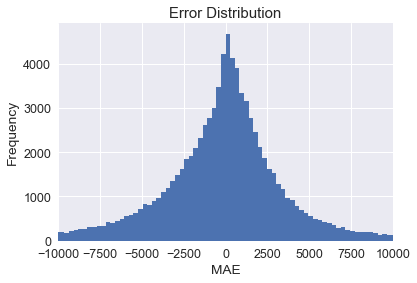

In [53]:
#Pred minus real
y_diff = np.exp(y_pred)- np.exp(y_test)
plt.hist(y_diff, bins=1000)
plt.xlim(xmin=-10000, xmax=10000)
plt.title('Error Distribution')
plt.ylabel('Frequency')
plt.xlabel('MAE')
plt.show()

Analizemos ahora donde cometemos los errores, es decir relacionaremos el error con el poder adquisitivo.

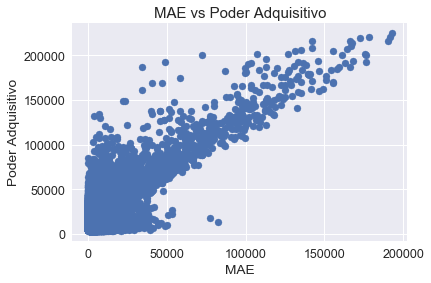

In [54]:
# MAE vs Poder Adquisitivo
y_diff = np.abs(np.exp(y_pred)- np.exp(y_test))
plt.scatter(y_diff, np.exp(y_test))
plt.title('MAE vs Poder Adquisitivo')
plt.ylabel('Poder Adquisitivo')
plt.xlabel('MAE')
plt.show()

Como podemos observar a mayor error mayor es el poder adquisitivo como cabe esperar. Veamos ahora el mismo gráfico usando el MAPE.

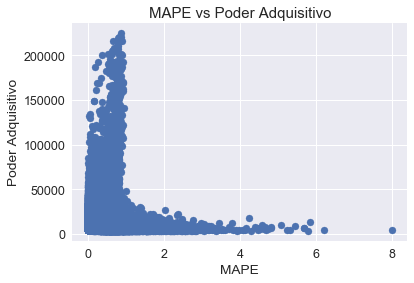

In [55]:
# MAPE vs Poder Adquisitivo
mape = np.absolute(np.exp(y_test) - np.exp(y_pred))/np.abs(np.exp(y_test))
plt.scatter(mape, np.exp(y_test))
plt.title('MAPE vs Poder Adquisitivo')
plt.ylabel('Poder Adquisitivo')
plt.xlabel('MAPE')
plt.show()

De esta manera podemos ver que cometemos errores más importantes cuándo el valor del poder adquisitivo es pequeño. En cambio, a medida que el valor adquisitivo crece no obtenemos tantos errores grandes proporcionalmente hablando. 

Esta situación no nos preocupa si suponemos que la entidad bancaria usa esta predicción en función de umbrales: el modelo puede predicir un poder adquisitivo de 8000€ para un usuario que realmente tiene un poder adquisitivo de 4000€ y cometer un error del 100%, pero no es un problema si el banco propone productos financieros para clientes con un poder adquisitivo por debajo del umbral de 10000€. Esta necesidad de negocio basada en umbrales motiva la creación de un modelo de adicional de evaluación. En la función siguiente podemos establecer el umbral mínimo, umbral máximo, y el "step" o intervalo para crear umbrales en el recorrido entre mínimo y máximo. Para cada intervalo, se obtienen los clientes del conjunto de test cuyo poder adquisitivo esté en el rango, y de éstos se obtienen el subgrupo de clientes cuyo poder adquisitivo predicho también se situa en el mismo rango.

In [56]:
def thresholds_evaluation(y_test, y_pred, minimo, maximo, step):
    thresholds = np.arange(minimo,maximo,step)
    df_index = []
    df_acc = []
    df_test = []
    df_pred = []
    for limit in thresholds:
        # límite inferior
        if limit == thresholds[0]:
            test_indices = np.where(np.exp(y_test)<limit)[0]
            test_num = test_indices.shape[0]
            pred_num = np.where(np.exp(y_pred[test_indices])<limit)[0].shape[0]
            acc = np.round(100.*pred_num/test_num,2)
            df_index.append("< "+str(limit)+"€")
            df_acc.append(acc)
            df_test.append(test_num)
            df_pred.append(pred_num)
            
        # límite superior
        elif limit == thresholds[-1]:
            test_indices = np.where(np.exp(y_test)>limit)[0]
            test_num = test_indices.shape[0]
            pred_num = np.where(np.exp(y_pred[test_indices])>limit)[0].shape[0]
            acc = np.round(100.*pred_num/test_num,2)
            ##print np.exp(y_test[test_indices])
            #print np.exp(y_pred[test_indices])
            df_index.append("> "+str(limit)+"€")
            df_acc.append(acc)
            df_test.append(test_num)
            df_pred.append(pred_num)
        
    # límites intermedios
        else:
            test_indices = np.where((np.exp(y_test)<limit) & (np.exp(y_test)>(limit-step)))[0]
            test_num = test_indices.shape[0]
            pred_num = np.where(np.exp(y_pred[test_indices])<limit)[0].shape[0]
            acc = np.round(100.*pred_num/test_num,2)
            df_index.append(str(limit-step)+"€ - "+str(limit)+"€")
            df_acc.append(acc)
            df_test.append(test_num)
            df_pred.append(pred_num)
            
    df = pd.DataFrame(data=df_test,index=df_index, columns=["Muestras de Test"]) 
    df["Muestras de Pred correspondientes"] = df_pred
    df["Precisión por Umbral (%)"] = df_acc
    return df

Para tener una visión general, mostramos la distribución con un umbral mínimo de 5000€, máximo de 60000€, y los umbrales intermediarios obtenidos cada 5000€. Observamos como el modelo tiene más dificultad con los extremos, sobretodo en el extremo inferior.

In [57]:
thresholds_evaluation(y_test, y_pred, 5000, 60000, 5000)

,Muestras de Test,Muestras de Pred correspondientes,Precisión por Umbral (%)
< 5000€,2314,35,1.51
5000€ - 10000€,26108,18450,70.67
10000€ - 15000€,27048,22670,83.81
15000€ - 20000€,15038,12739,84.71
20000€ - 25000€,8008,6850,85.54
25000€ - 30000€,4918,4321,87.86
30000€ - 35000€,2740,2434,88.83
35000€ - 40000€,1528,1364,89.27
40000€ - 45000€,878,796,90.66
45000€ - 50000€,567,517,91.18


La distribución del poder adquisitivo centrada entorno a los 13000€ justifica mirar con más detalle esa zona. Reducimos el intervalo a 2000€ por lo que la precisión disminuye, y conseguimos conocer el rendimiento del modelo cuando variaciones de 2000€ no son relevantes desde el punto de visto de negocio.

Podría agregarse un parámetro de tolerancia para tratar mejor los valores que se encuentran muy cerca de los umbrales.

In [58]:
thresholds_evaluation(y_test, y_pred, 5000, 30000, 2000)

,Muestras de Test,Muestras de Pred correspondientes,Precisión por Umbral (%)
< 5000€,2314,35,1.51
5000€ - 7000€,10245,5067,49.46
7000€ - 9000€,8786,4041,45.99
9000€ - 11000€,12799,8495,66.37
11000€ - 13000€,11743,8327,70.91
13000€ - 15000€,9583,7005,73.10
15000€ - 17000€,7237,5341,73.80
17000€ - 19000€,5571,4201,75.41
19000€ - 21000€,4174,3179,76.16
21000€ - 23000€,3356,2613,77.86


### 6. Modelo final y generación de predicciones

Con el objetivo de generar las predicciones definitivas de los clientes incluidos en el fichero Test.txt, entrenamos el modelo con los parámetros más adecuados, obtenidos del Grid Search anterior, sobre el conjunto completo de los datos de Train.txt. 

In [59]:
train_filename = "Dataset_Salesforce_Predictive_Modelling_TRAIN.txt"
df = pd.read_csv(path+train_filename,low_memory=False)

#Remplazamos un valor hexadecimal en la variable categórica Socio_Demo_01 por su correspondiente decimal
#para que no de problemas de tipo de datos luego.
df["Socio_Demo_01"].replace(to_replace='0X301', value=769, inplace=True)
df["Socio_Demo_01"] = df["Socio_Demo_01"].astype(np.float64)

# NA
print (df.shape)
df = df.dropna().reset_index(drop = True)
print ("Duplicated: "+str(np.any(df.duplicated().values)))
print (df.shape)

# Outliers
print (df.shape)
df = df[df['Poder_Adquisitivo'] < np.percentile(df['Poder_Adquisitivo'], 99.9)]
print (df.shape)

#Creación de buckets para Socio_Demo_01
bucket_1,bucket_2,bucket_3,bucket_others = buckets(df)

#Labels con transformacion logaritmica
y = np.log(df["Poder_Adquisitivo"].values)

#Dataset principal sin labels
df = df.drop("Poder_Adquisitivo", axis = 1)

#Aplicamos las transformaciones
minmax = []
onehot = []
X, f_names, minmax1, onehot1 = transform(df,numerical,categorical,minmax,onehot,bucket_1,bucket_2,bucket_3,bucket_others)

(363834, 89)
Duplicated: False
(363224, 89)
(363224, 89)
(362860, 89)
Features Numéricas: 50
Features Categóricas sin OneHot encoding: 24
Features Categóricas con OneHot encoding: 7
Dataset: (362860, 81)


In [60]:
LR = LinearRegression()
LR.fit(X, y)
lr = pd.DataFrame(data=LR.predict(X),columns = ["lr"])
X = sp.hstack([X,lr])
print (X.shape)

(362860, 82)


Entrenamos el modelo final.

In [61]:
model = xgb.train({"max_depth": 25,
                  "learning_rate": 0.01,
                  "min_child_weight":3,
                  "gamma":0.3,
                  "subsample":0.75,
                  "colsample_bytree":0.75,
                  "seed":11},
                  xgb.DMatrix(X, label=y),1000)

In [62]:
# save model to file
pickle.dump(model, open("model.dat", "wb"))
#model = pickle.load(open("model.dat", "rb"))

Cargamos el fichero Test.txt y aplicamos las mismas transformaciones de variables aplicadas sobre el conjunto de Train, teniendo especial cuidado de utilizar la misma función de MinMaxScaler, ya entrenada y empleada en el paso justamente anterior. 

In [63]:
test_filename = "Dataset_Salesforce_Predictive_Modelling_TEST.txt"
df_target = pd.read_csv(path+test_filename,low_memory=False)

#Remplazamos un valor hexadecimal en la variable categórica Socio_Demo_01 por su correspondiente decimal
#para que no de problemas de tipo de datos luego.
df_target["Socio_Demo_01"].replace(to_replace='0X301', value=769, inplace=True)
df_target["Socio_Demo_01"] = df_target["Socio_Demo_01"].astype(np.float64)

# Quitamos NA si aplica
print (df_target.shape)
df_target = df_target.dropna().reset_index(drop = True)
print ("Duplicated: "+str(np.any(df_target.duplicated().values)))
print (df_target.shape)

#Aplicamos las transformaciones
X_to_predict, trash1, trash2, trash3 = transform(df_target,numerical,categorical,minmax1,onehot1,bucket_1,bucket_2,bucket_3,bucket_others, train = False)

(156315, 88)
Duplicated: False
(156041, 88)
Features Numéricas: 50
Features Categóricas sin OneHot encoding: 24
Features Categóricas con OneHot encoding: 7
Dataset: (156041, 81)


Obtenemos las predicciones de la regresión linear, lo añadimos al dataset, obtenemos las predicciones del modelo final, y aplicamos una transformación exponencial.

In [64]:
lr_to_predict = pd.DataFrame(data=LR.predict(X_to_predict),columns = ["lr"])
X_to_predict = sp.hstack([X_to_predict,lr_to_predict])
y_pred = model.predict(xgb.DMatrix(X_to_predict))
print (y_pred)
y_pred = np.exp(y_pred)
print (y_pred)

[10.133896   9.5898485  9.968007  ...  8.731251   9.551815   8.637775 ]
[25182.281  14615.655  21332.928  ...  6193.4697 14070.209   5640.7676]


Exportamos el resultado a un fichero Test_Mission.txt en el formato solicitado.

In [65]:
result_filename = "Test_Mission.txt"

y_pred_data=pd.DataFrame(data=y_pred, columns=["PA_Est"])
customerid=pd.DataFrame(data=df_target["ID_Customer"])
output = customerid.assign(PA_Est=y_pred_data)
output.to_csv(path+result_filename,sep=",", encoding="utf-8", index=False,quoting=None)
print (output.shape)

(156041, 2)


### 7. Interpretabilidad y conclusiones

In [67]:
import shap
shap.initjs() 

La explicabilidad de un modelo predictivo es un aspecto clave para que una entidad financiera pueda utilizarlo y ser transparente con sus clientes, más teniendo en cuenta la última reglamentación europea al respecto (GDPR).  
El proyecto SHAP (SHapley Additive exPlanations) plantea explicar la salida de cualquier modelo de Machine Learning basandose en las contribuciones de las variables empleadas en el modelo. Para ello utiliza conceptos de la teoría de juegos. Puede encontrarse más información en:
https://github.com/slundberg/shap

Obtenemos las contribuciones o "shap values" de cada característica a las predicciones.

In [68]:
shap_values = model.predict(xgb.DMatrix(X_to_predict.todense()[0:1000]), pred_contribs=True)

In [69]:
X_to_predict_df = pd.DataFrame(data=X_to_predict.todense()[0:1000],columns = np.append([f_names],'lr')) 

Para una predicción individual, observamos los features que más contribuyen a incrementar o decrementar dicha predicción tomando como referencia un base value (promedio de todas las predicciones) en rojo, y las que más contribuyen a dismimuir el valor de la predicción en azul. Es interesante ver como, aunque algunas características se repiten para diferentes muestras, cada una aporta diferentes contribuciones, de forma positiva o negativa. Debe tomarse el logaritmo de los valores "base value" y "output value" en estas figuras para conseguir el poder adquisitivo en euros.

In [70]:
n=0
shap.force_plot(shap_values[n,:], X_to_predict_df.iloc[n,:])

In [71]:
n=6
shap.force_plot(shap_values[n,:], X_to_predict_df.iloc[n,:])

Para tener una idea genérica de la importancia de los features y de cómo afectan a la predicción, la siguiente visualización nos muestra la distribución de el impacto que cada feature tiene en la salida del modelo, donde los features estan ordenados por orden de impacto. El color representa el valor de cada feature (valores altos en rojo, bajos en azul).

Vemos que, como es de suponer, a mayor importes de los saldos (por ejemplo "Imp_Sal_21"), mayor es su contribución a aumentar el poder adquisitivo. La variable creada de la regresión lineal está entre las más relevantes, al igual que algunos saldos, consumos, y la variable Socio_Demo_03 que muy probablemente sea la edad (por su distribución).

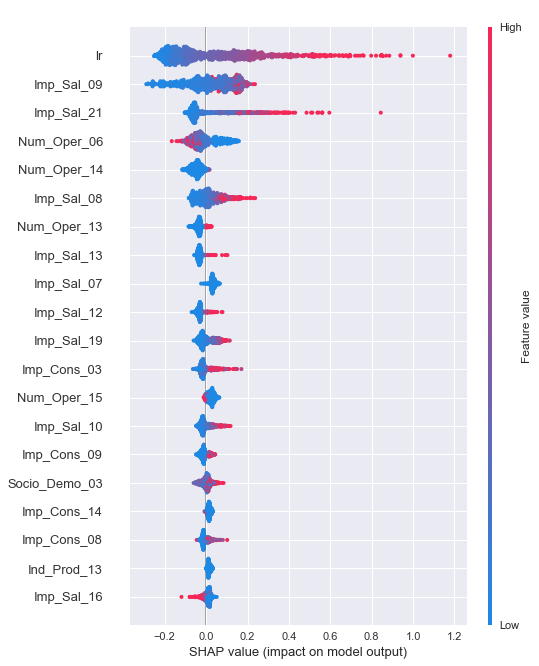

In [72]:
shap.summary_plot(shap_values, X_to_predict_df)

A lo largo de este proyecto hemos realizado una exploración exhaustiva de los datos, que ha justificado una serie de transformaciones y creaciones de nuevas variables, como por ejemplo aplicar el logaritmo al Poder Adquisitivo. Tras probar varios modelos predictivos, aplicamos un modelo de ensamblado de árboles de decisión para regresión, XGBoost, que evaluamos mediante Mean Absolute Error y Mean Absolute Percentage Error principalmente. Entrenamos un modelo final sobre el conjunto completo de train y generamos las predicciones de Poder Adquisitivo sobre el conjunto de test, adjuntas a este documento. Mostramos finalmente las métricas obtenidas.

In [73]:
results = pd.DataFrame(data = [mae_100, mae_95, mape_100, mape_95], index = ["MAE (100%)","MAE (95%)","MAPE (100%)","MAPE (95%)"], columns = ["Evaluation Table"])
results

,Evaluation Table
MAE (100%),3720.910970
MAE (95%),2597.168445
MAPE (100%),0.237231
MAPE (95%),0.184168
